In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
#import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_json('jsonclean/fulldata.json')



# SPLIT

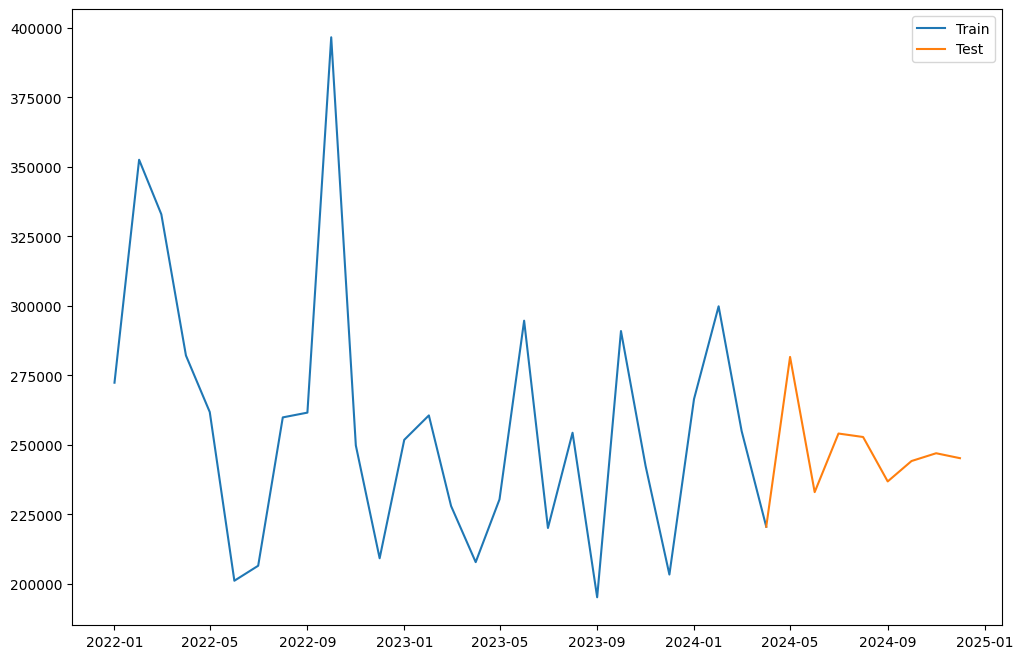

In [3]:
# split data into training and test sets 

train = df[:int(0.8*(len(df)))]
test = df[int(0.77*(len(df))):]

# visualize train and test data

plt.figure(figsize=(12,8))
plt.plot(train['Unique_visitors'], label='Train')
plt.plot(test['Unique_visitors'], label='Test')
plt.legend()
plt.show()

# SEASONAL DECOMPOSITION

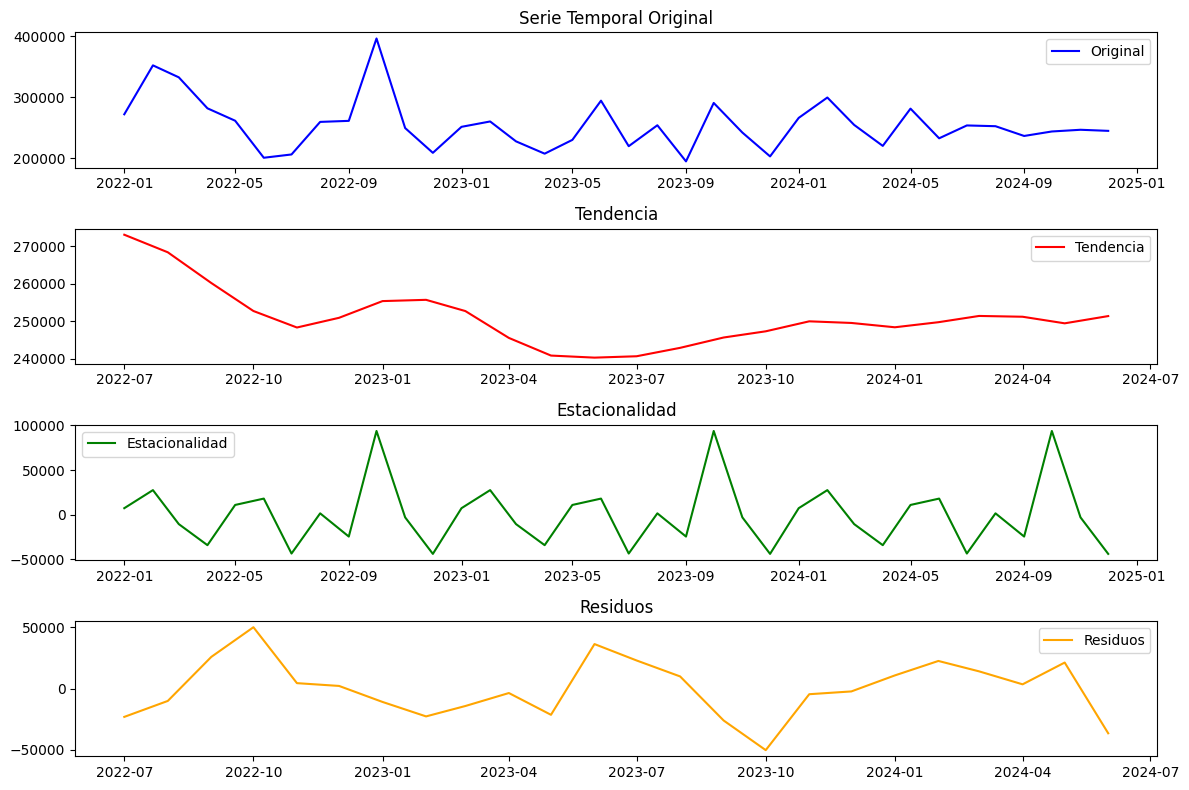

In [4]:
# Optionally, visualize the series and decompose it to confirm seasonality:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['Unique_visitors'], model='additive')

# Obtención de las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residuals = decomposition.resid

# Graficar las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df['Unique_visitors'], label='Original', color='blue')
plt.legend()
plt.title('Serie Temporal Original')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='red')
plt.legend()
plt.title('Tendencia')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()
plt.title('Estacionalidad')

plt.subplot(414)
plt.plot(residuals, label='Residuos', color='orange')
plt.legend()
plt.title('Residuos')

plt.tight_layout()
plt.show()


# BUSCANDO PARAMETROS

## OPTUNA

In [5]:
# Define the objective function that accepts a criterion parameter.
def objective(trial, criterion):
    # Define the search space for SARIMA parameters.
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 3)
    
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    m = 12  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)

    try:
        # Fit the SARIMAX model on the training data.
        model = SARIMAX(train['Unique_visitors'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        trend='c')
        model_fit = model.fit(disp=False)
        
        # Generate predictions for the test period.
        predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
        
        # Calculate RMSE.
        rmse = np.sqrt(mean_squared_error(test['Unique_visitors'], predictions))
        
        # Calculate MAPE.
        mape = np.mean(np.abs((test['Unique_visitors'] - predictions) / test['Unique_visitors'])) * 100
        
        # Extract AIC and BIC from the fitted model.
        aic = model_fit.aic
        bic = model_fit.bic
        
    except Exception as e:
        # In case of error (e.g., model not converging), return a high penalty value.
        return float('inf')
    
    # Return the corresponding metric based on the criterion.
    if criterion == 'rmse':
         return rmse
    elif criterion == 'mape':
         return mape
    elif criterion == 'aic':
         return aic
    elif criterion == 'bic':
         return bic
    else:
         return rmse  # Default to RMSE if criterion is unknown.

# Define the criteria we want to optimize.
criteria = ['rmse', 'mape', 'aic', 'bic']
best_trials = {}
n_trials = 50  # Number of trials for each optimization study.

# Run a separate optimization study for each criterion.
for crit in criteria:
    print(f"Optimizing for {crit.upper()}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, crit), n_trials=n_trials)
    best_trials[crit] = study.best_trial
    print(f"Best {crit.upper()}: {study.best_value}")
    print(f"Parameters: {study.best_params}\n")

# Display the best trials for each criterion.
for crit in criteria:
    print(f"Criterion: {crit.upper()}")
    print(f"Best Value: {best_trials[crit].value}")
    print(f"Best Parameters: {best_trials[crit].params}\n")

[I 2025-04-10 16:19:11,017] A new study created in memory with name: no-name-f2b338c2-4213-46b3-9c79-e2a54dcd5186
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: d

Optimizing for RMSE...


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments wi

Best RMSE: 12365.358040338408
Parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}

Optimizing for MAPE...


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments wi

Best MAPE: 4.233409755331222
Parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0}

Optimizing for AIC...


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

Best AIC: 371.38779223946557
Parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0}

Optimizing for BIC...


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
[I 2025-04-10 16:19:30,575] Trial 1 finished with value: 706.447367620087 and parameters: {'p': 3, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 2}. Best is trial 0 with value: 382.2142580216885.
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/e

Best BIC: 375.09955361640294
Parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}

Criterion: RMSE
Best Value: 12365.358040338408
Best Parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}

Criterion: MAPE
Best Value: 4.233409755331222
Best Parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 0, 'D': 0, 'Q': 0}

Criterion: AIC
Best Value: 371.38779223946557
Best Parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 1, 'D': 1, 'Q': 0}

Criterion: BIC
Best Value: 375.09955361640294
Best Parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 1}



In [6]:

# --- Data Preparation ---
# Make sure you have defined your 'train' and 'test' DataFrames,
# and that they contain the column 'Unique_visitors' (your variable of interest).
# For example:
# train = your_dataframe.iloc[:train_index]
# test = your_dataframe.iloc[train_index:]

# --- Objective Function ---
def objective(trial):
    """
    This function defines the multi-objective to optimize.
    For each trial, it:
      - Defines a search space for the SARIMA parameters (p, d, q, P, D, Q).
      - Fits a SARIMAX model on the training data (using the 'Unique_visitors' column).
      - Forecasts for the test period.
      - Calculates four criteria:
          RMSE: Root Mean Squared Error.
          MAPE: Mean Absolute Percentage Error.
          AIC: Akaike Information Criterion.
          BIC: Bayesian Information Criterion.
      - Returns these four metrics as a tuple.
    
    If an error occurs (for instance, non-convergence), it returns very high penalty values.
    """
    # Non-seasonal parameters
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 1)
    q = trial.suggest_int('q', 0, 3)
    
    # Seasonal parameters
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    m = 12  # Seasonal period (e.g., 12 for monthly data with yearly seasonality)
    
    try:
        # Fit SARIMAX model on the training data.
        model = SARIMAX(train['Unique_visitors'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, m),
                        trend='c')
        model_fit = model.fit(disp=False)
        
        # Generate predictions for the test period.
        predictions = model_fit.predict(start=len(train),
                                        end=len(train) + len(test) - 1,
                                        typ='levels')
        
        # Calculate RMSE.
        rmse = np.sqrt(mean_squared_error(test['Unique_visitors'], predictions))
        
        # Calculate MAPE.
        mape = np.mean(np.abs((test['Unique_visitors'] - predictions) / test['Unique_visitors'])) * 100
        
        # Get AIC and BIC from the fitted model.
        aic = model_fit.aic
        bic = model_fit.bic
        
    except Exception as e:
        # Return high penalty values if the model fails to fit.
        return float('inf'), float('inf'), float('inf'), float('inf')
    
    return rmse, mape, aic, bic

# --- Multi-Objective Study ---
# Create a study that minimizes all four objectives.
study = optuna.create_study(directions=["minimize", "minimize", "minimize", "minimize"])

# Run the optimization (here we use 50 trials; you can increase this for better results).
study.optimize(objective, n_trials=50)

# --- Display Pareto-Optimal Trials ---
print("Pareto-optimal trials (the best trade-offs among RMSE, MAPE, AIC, and BIC):")
for t in study.best_trials:
    print("Trial number:", t.number)
    print("Objectives (RMSE, MAPE, AIC, BIC):", t.values)
    print("Parameters:", t.params)
    print("-" * 40)

[I 2025-04-10 16:19:35,810] A new study created in memory with name: no-name-a3c3dbd3-18a7-484c-a1fa-74316d94a333
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/base/model.py:607: Co

Pareto-optimal trials (the best trade-offs among RMSE, MAPE, AIC, and BIC):
Trial number: 2
Objectives (RMSE, MAPE, AIC, BIC): [14630.556812825944, 5.443053873211636, 691.2473379697218, 699.240565030773]
Parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}
----------------------------------------
Trial number: 4
Objectives (RMSE, MAPE, AIC, BIC): [33586.336590592466, 12.43212287723707, 393.8925906458806, 400.07330042379886]
Parameters: {'p': 2, 'd': 0, 'q': 2, 'P': 1, 'D': 1, 'Q': 1}
----------------------------------------
Trial number: 5
Objectives (RMSE, MAPE, AIC, BIC): [14630.556812825944, 5.443053873211636, 691.2473379697218, 699.240565030773]
Parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 1}
----------------------------------------
Trial number: 7
Objectives (RMSE, MAPE, AIC, BIC): [44230.67054400215, 11.26413660482631, 391.33034095196194, 399.82881689659956]
Parameters: {'p': 3, 'd': 0, 'q': 2, 'P': 2, 'D': 1, 'Q': 2}
----------------------------------------


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



--- Applying SARIMAX from Trial 3 with Parameters: {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 2} ---
Metrics: MSE: 3644792229.90, MAE: 54817.01, RMSE: 60372.11, R2: -13.35
AIC: 372.49, BIC: 377.45


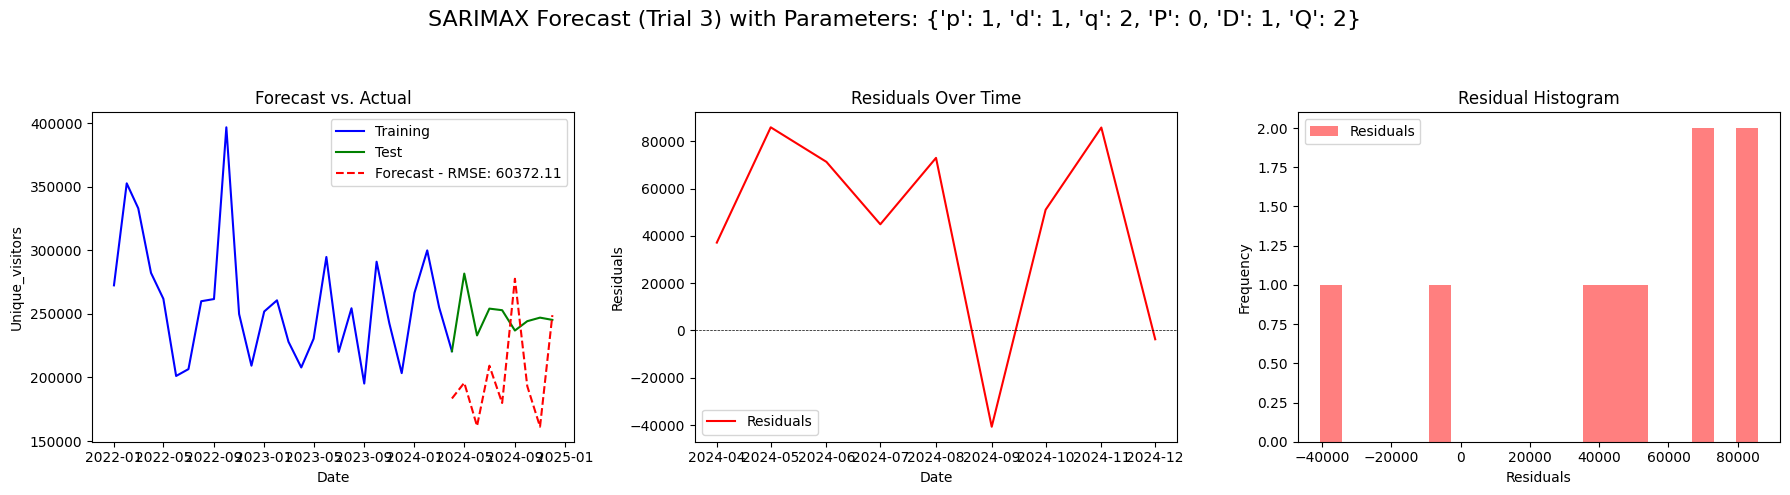


--- Applying SARIMAX from Trial 4 with Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 2, 'D': 1, 'Q': 2} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metrics: MSE: 3282209879.31, MAE: 51149.97, RMSE: 57290.57, R2: -11.92
AIC: 378.40, BIC: 385.48


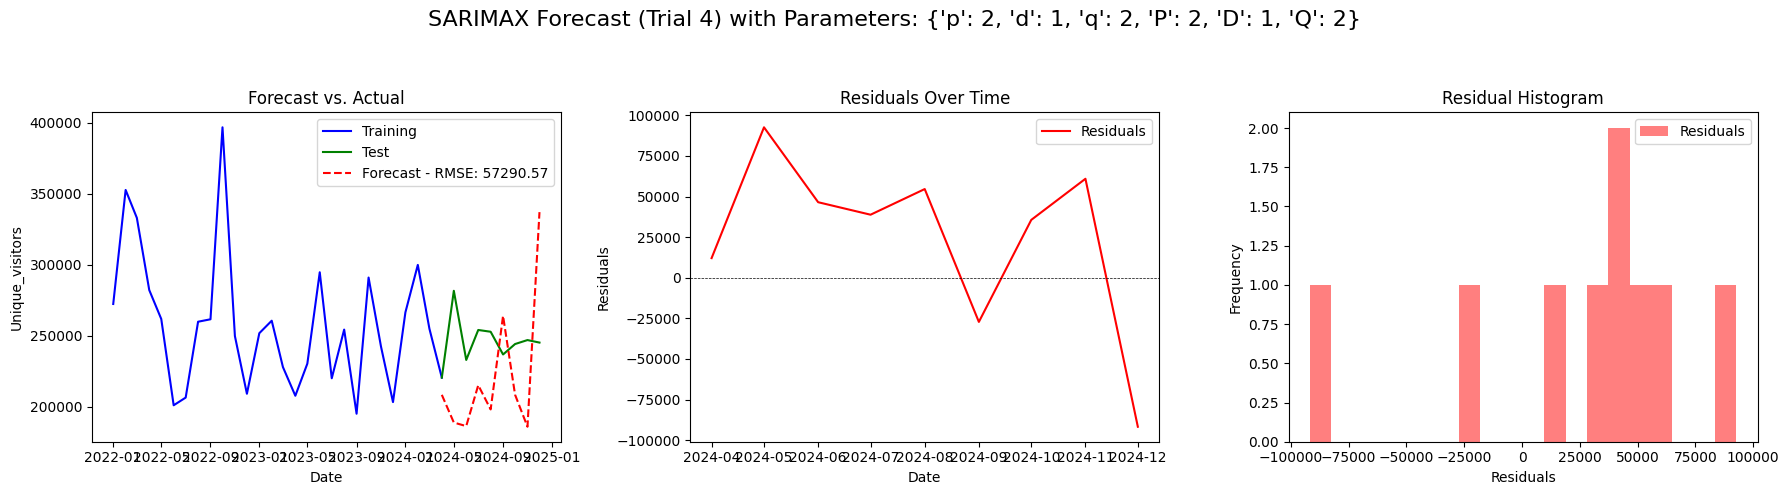


--- Applying SARIMAX from Trial 14 with Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 2, 'D': 1, 'Q': 0} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metrics: MSE: 3313494538.45, MAE: 51247.71, RMSE: 57562.96, R2: -12.05
AIC: 374.41, BIC: 380.07


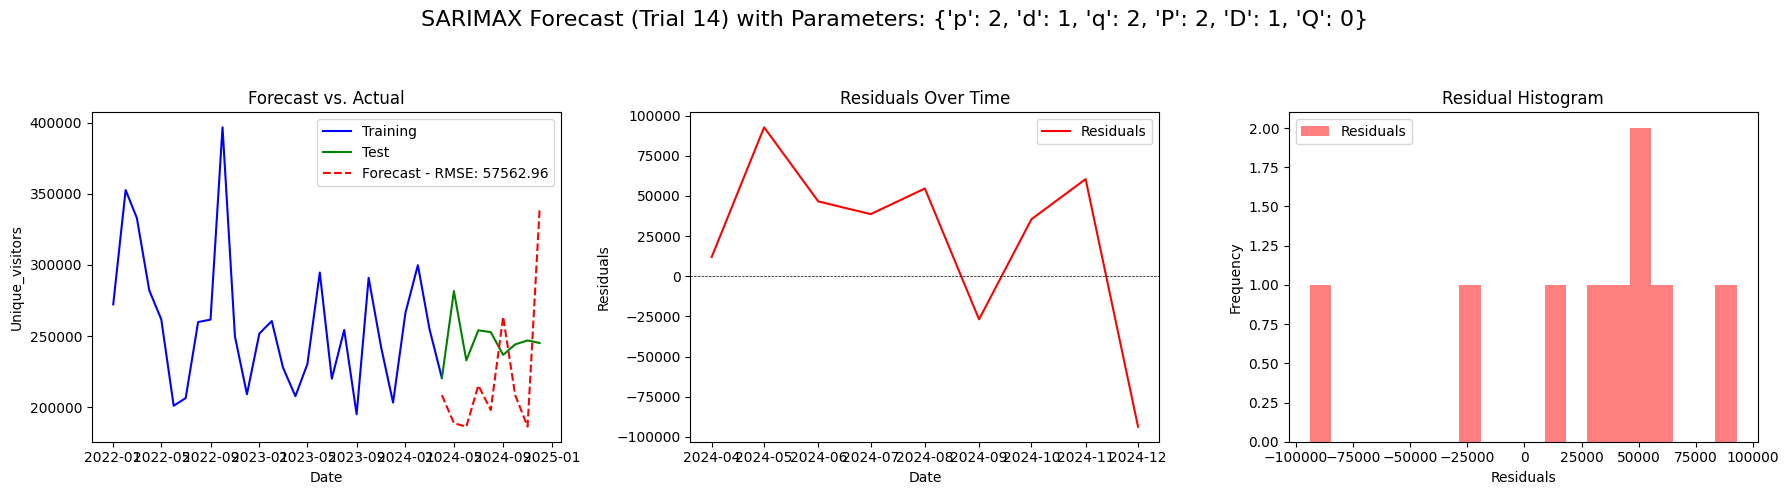


--- Applying SARIMAX from Trial 16 with Parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 0} ---
Metrics: MSE: 486087339.91, MAE: 17793.97, RMSE: 22047.39, R2: -0.91
AIC: 674.08, BIC: 679.26


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


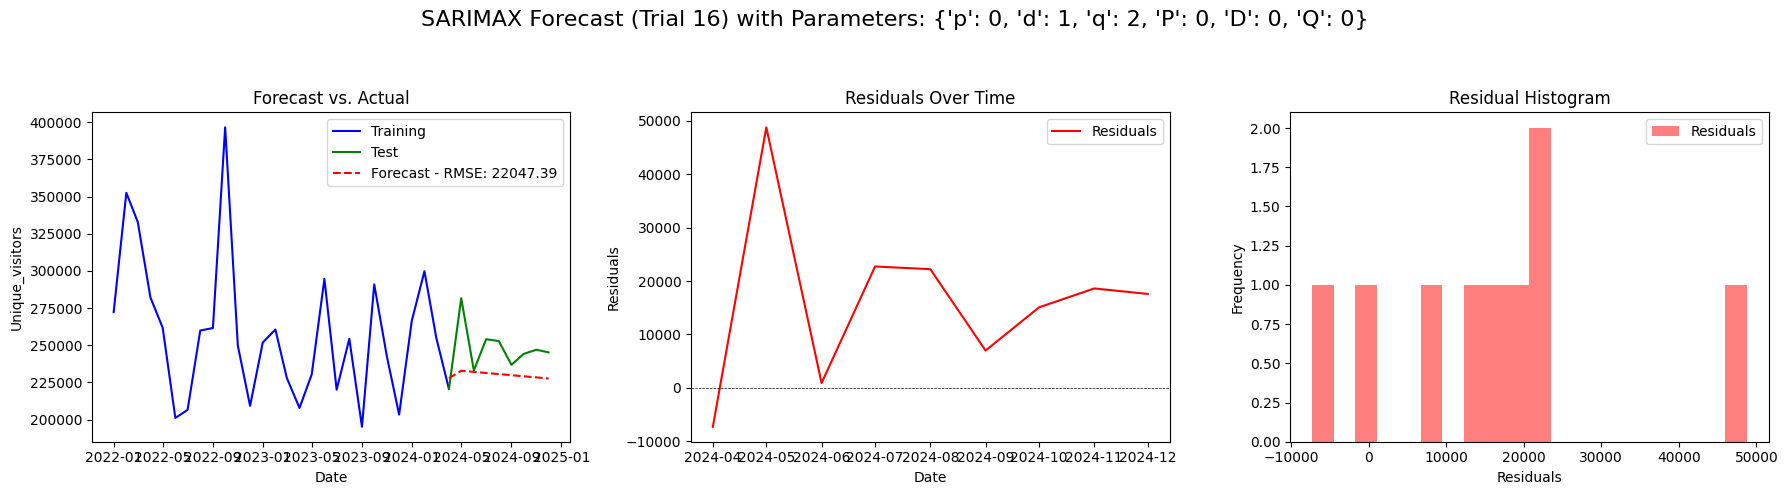


--- Applying SARIMAX from Trial 18 with Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 2} ---
Metrics: MSE: 2423693940.96, MAE: 44716.22, RMSE: 49231.03, R2: -8.54
AIC: 375.07, BIC: 380.73


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


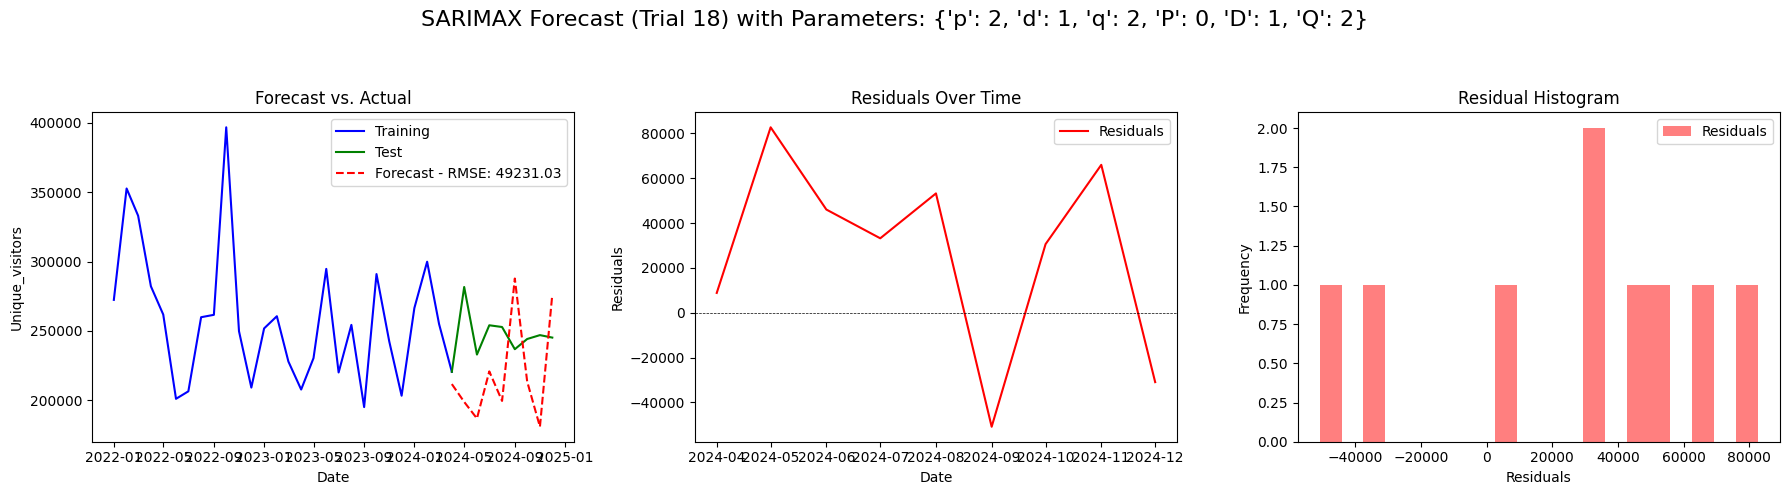


--- Applying SARIMAX from Trial 21 with Parameters: {'p': 0, 'd': 0, 'q': 2, 'P': 2, 'D': 1, 'Q': 0} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metrics: MSE: 1244293242.54, MAE: 26716.91, RMSE: 35274.54, R2: -3.90
AIC: 394.51, BIC: 399.14


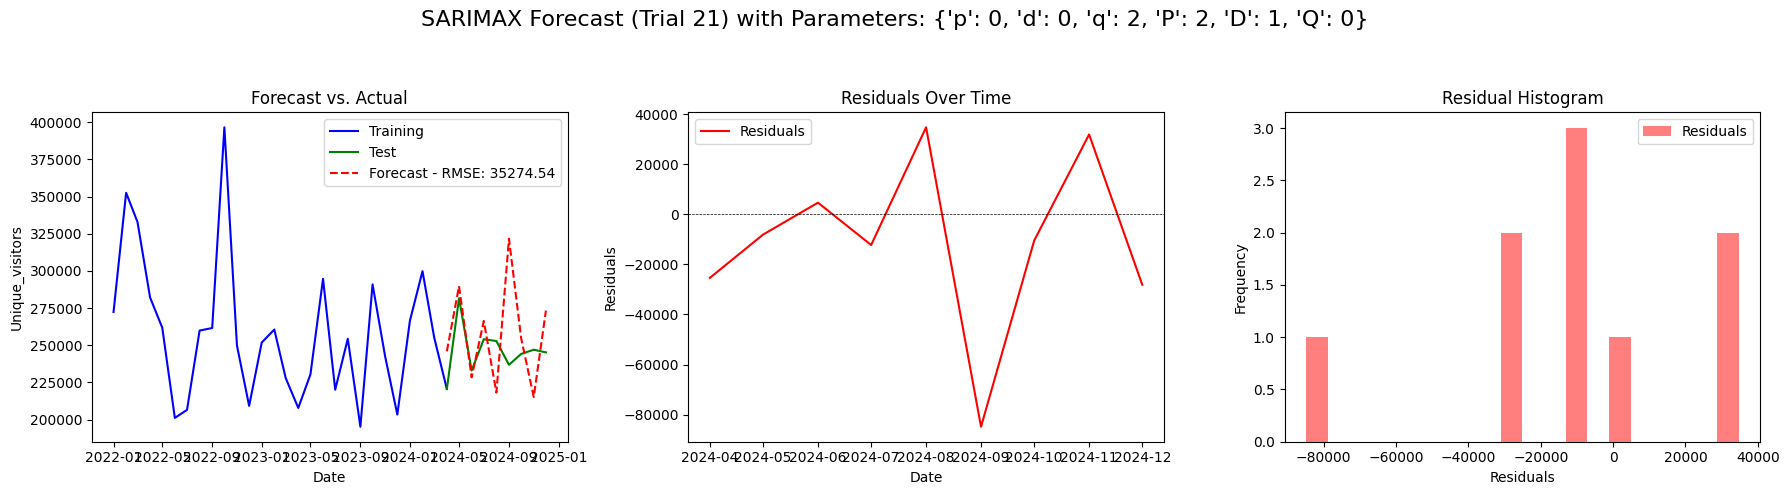


--- Applying SARIMAX from Trial 22 with Parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0} ---
Metrics: MSE: 1515810858.29, MAE: 35176.11, RMSE: 38933.42, R2: -4.97
AIC: 674.76, BIC: 677.36


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


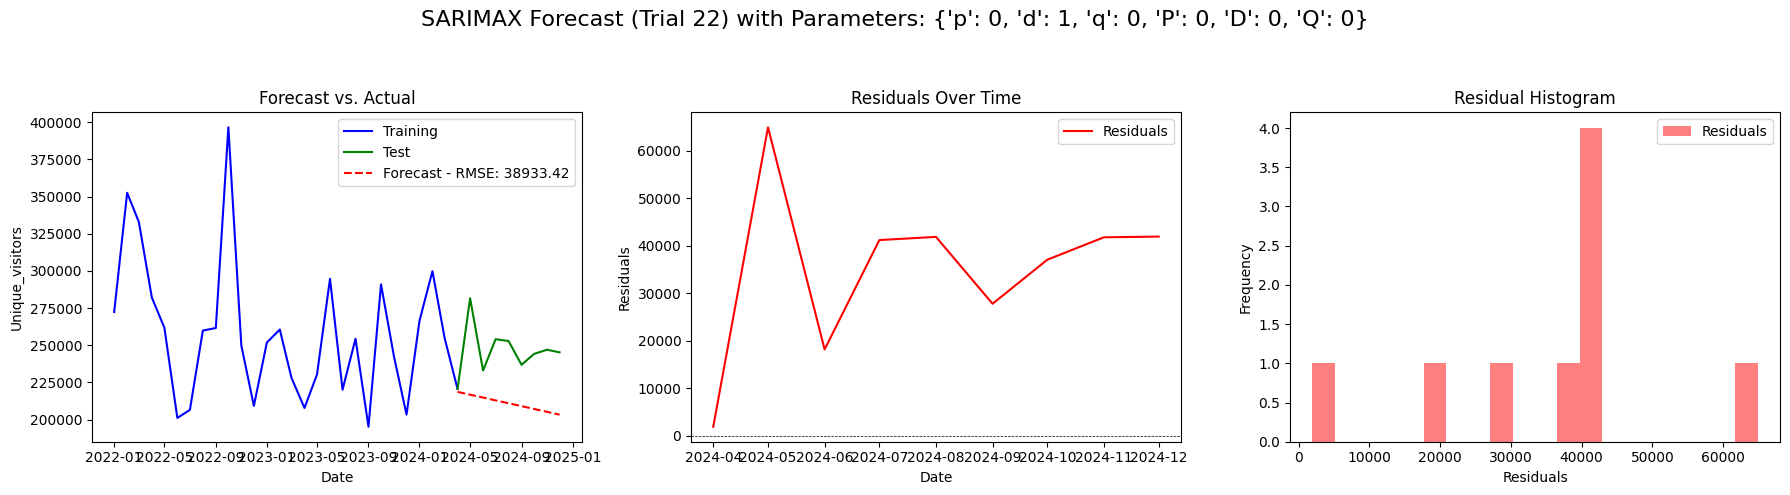


--- Applying SARIMAX from Trial 23 with Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 0} ---
Metrics: MSE: 2016862600.79, MAE: 35634.89, RMSE: 44909.49, R2: -6.94
AIC: 375.26, BIC: 380.22


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


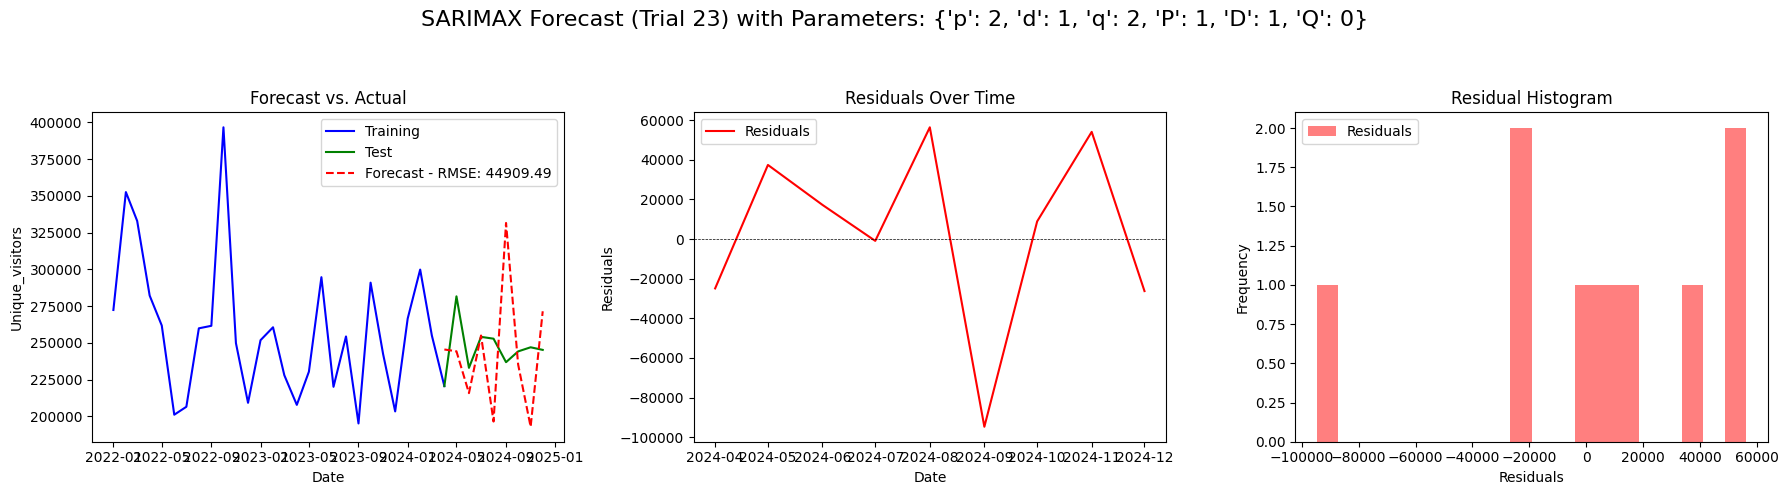


--- Applying SARIMAX from Trial 27 with Parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2} ---
Metrics: MSE: 1493201567.92, MAE: 34690.11, RMSE: 38641.97, R2: -4.88
AIC: 375.45, BIC: 380.40


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


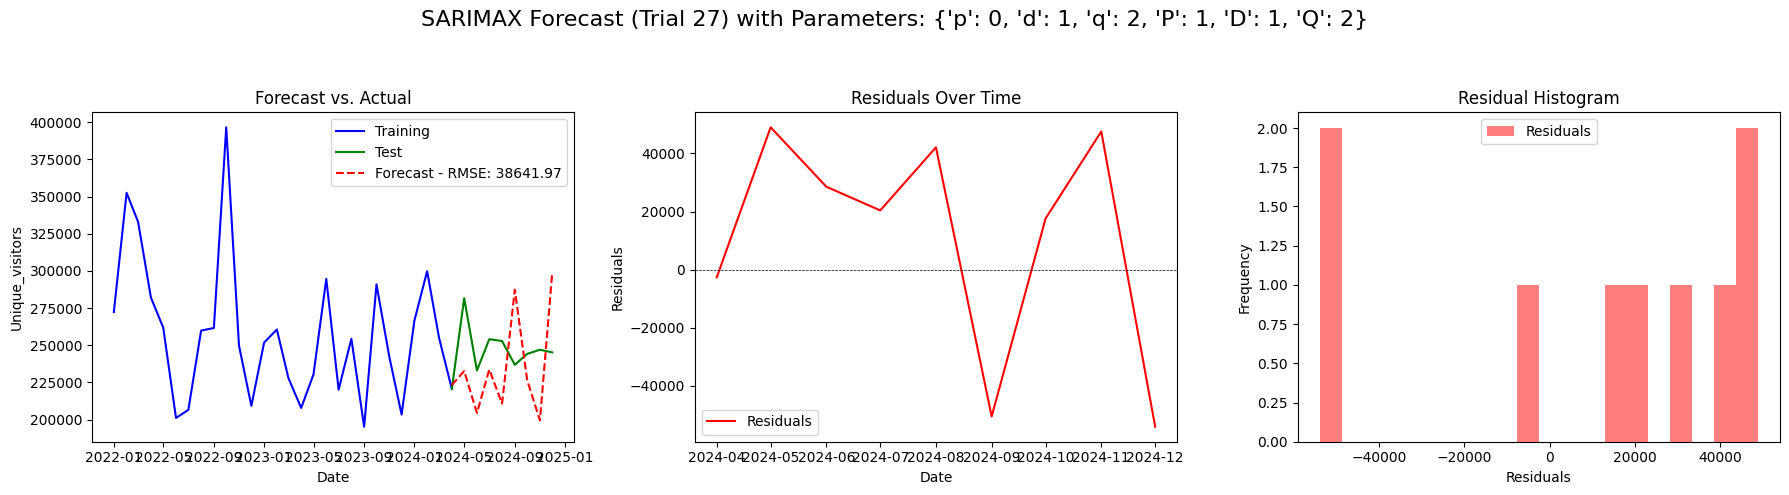


--- Applying SARIMAX from Trial 29 with Parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2} ---
Metrics: MSE: 1493201567.92, MAE: 34690.11, RMSE: 38641.97, R2: -4.88
AIC: 375.45, BIC: 380.40


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


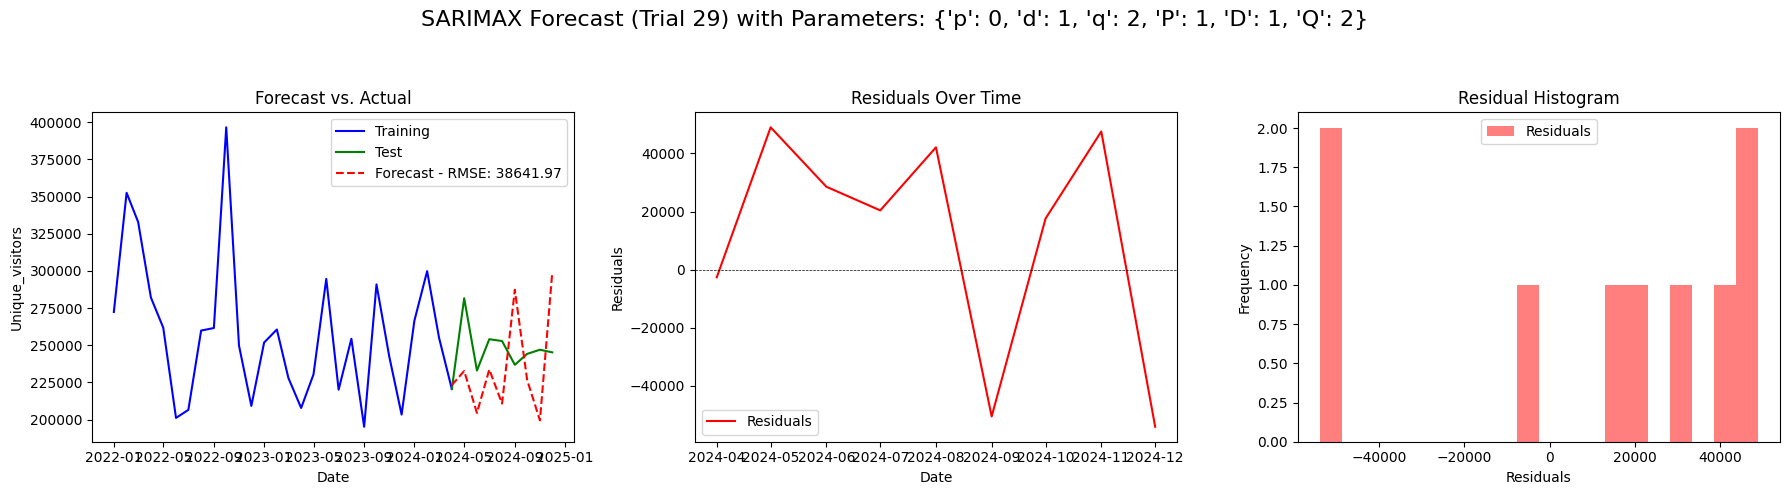


--- Applying SARIMAX from Trial 37 with Parameters: {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 2} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metrics: MSE: 1228681099.10, MAE: 24999.77, RMSE: 35052.55, R2: -3.84
AIC: 398.30, BIC: 403.70


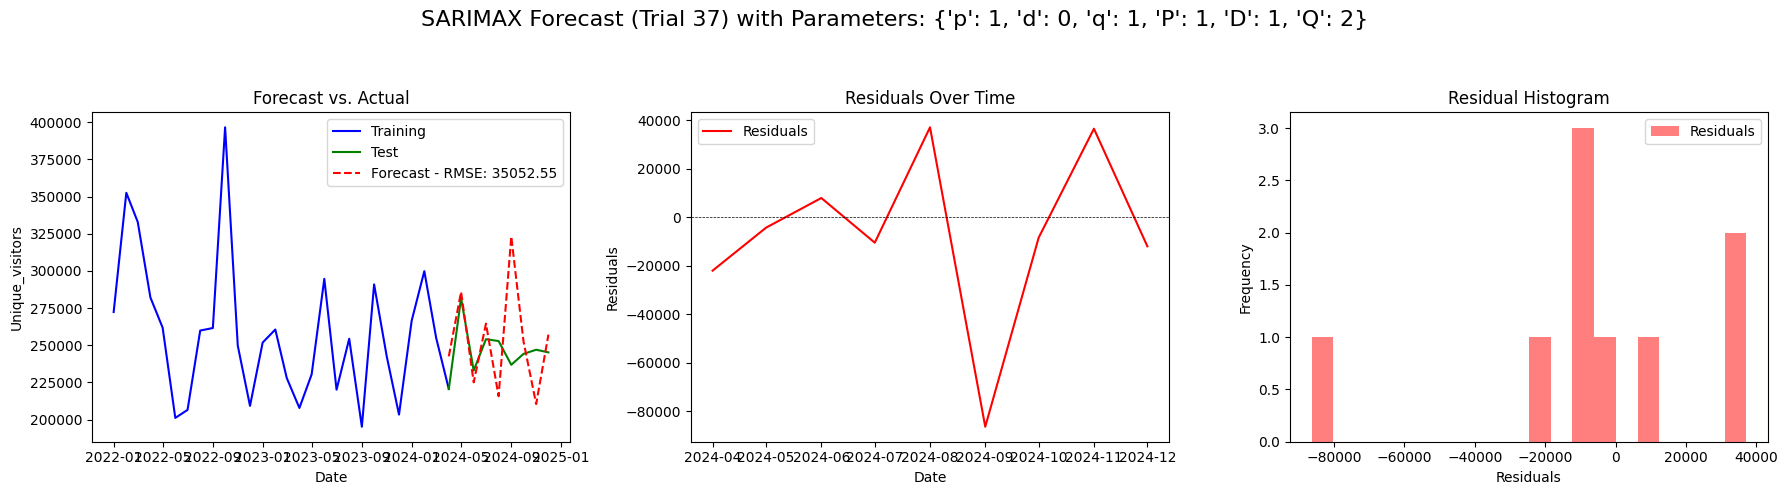

In [7]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.api import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # ---------------------------
# # Pareto-Optimal Trials (from your results)
# # ---------------------------
# pareto_params = [
#     {'trial': 3, 'params': {'p': 1, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 2}},
#     {'trial': 4, 'params': {'p': 2, 'd': 1, 'q': 2, 'P': 2, 'D': 1, 'Q': 2}},
#     {'trial': 14, 'params': {'p': 2, 'd': 1, 'q': 2, 'P': 2, 'D': 1, 'Q': 0}},
#     {'trial': 16, 'params': {'p': 0, 'd': 1, 'q': 2, 'P': 0, 'D': 0, 'Q': 0}},
#     {'trial': 18, 'params': {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 2}},
#     {'trial': 21, 'params': {'p': 0, 'd': 0, 'q': 2, 'P': 2, 'D': 1, 'Q': 0}},
#     {'trial': 22, 'params': {'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 0}},
#     {'trial': 23, 'params': {'p': 2, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 0}},
#     {'trial': 27, 'params': {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2}},
#     {'trial': 29, 'params': {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 1, 'Q': 2}},
#     {'trial': 37, 'params': {'p': 1, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 2}}
# ]

# # ---------------------------
# # Define a function to calculate metrics
# # ---------------------------
# def calculate_metrics(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     return mse, mae, rmse, r2

# # ---------------------------
# # Loop over each Pareto-optimal parameter set and plot a compact grid
# # ---------------------------
# for item in pareto_params:
#     trial_no = item['trial']
#     params = item['params']
#     print(f"\n--- Applying SARIMAX from Trial {trial_no} with Parameters: {params} ---")
    
#     # Define non-seasonal and seasonal orders
#     order = (params['p'], params['d'], params['q'])
#     seasonal_order = (params['P'], params['D'], params['Q'], 12)  # Assuming seasonal period of 12
    
#     # Build and fit the SARIMAX model on training data
#     sarima_model = SARIMAX(train['Unique_visitors'],
#                            order=order,
#                            seasonal_order=seasonal_order,
#                            trend='c')
#     sarima_fit = sarima_model.fit(disp=False)
    
#     # Forecast using get_forecast for the test period length
#     forecast_obj = sarima_fit.get_forecast(steps=len(test))
#     sarima_predictions = forecast_obj.predicted_mean
#     sarima_predictions.index = test.index  # Align forecast index with test data
    
#     # Calculate performance metrics
#     mse, mae, rmse, r2 = calculate_metrics(test['Unique_visitors'], sarima_predictions)
#     print(f"Metrics: MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
#     print(f"AIC: {sarima_fit.aic:.2f}, BIC: {sarima_fit.bic:.2f}")
    
#     # Calculate residuals
#     sarima_residuals = test['Unique_visitors'] - sarima_predictions
    
#     # Create a compact grid with 1 row and 3 columns for the plots
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     fig.suptitle(f'SARIMAX Forecast (Trial {trial_no}) with Parameters: {params}', fontsize=16)
    
#     # Plot 1: Forecast vs. Actual Data
#     axs[0].plot(train.index, train['Unique_visitors'], label='Training', color='blue')
#     axs[0].plot(test.index, test['Unique_visitors'], label='Test', color='green')
#     axs[0].plot(test.index, sarima_predictions, label=f'Forecast - RMSE: {rmse:.2f}', linestyle='--', color='red')
#     axs[0].set_xlabel('Date')
#     axs[0].set_ylabel('Unique_visitors')
#     axs[0].set_title('Forecast vs. Actual')
#     axs[0].legend()
    
#     # Plot 2: Residuals Over Time
#     axs[1].plot(test.index, sarima_residuals, label='Residuals', color='red')
#     axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
#     axs[1].set_xlabel('Date')
#     axs[1].set_ylabel('Residuals')
#     axs[1].set_title('Residuals Over Time')
#     axs[1].legend()
    
#     # Plot 3: Histogram of Residuals
#     axs[2].hist(sarima_residuals, bins=20, color='red', alpha=0.5, label='Residuals')
#     axs[2].set_xlabel('Residuals')
#     axs[2].set_ylabel('Frequency')
#     axs[2].set_title('Residual Histogram')
#     axs[2].legend()
    
#     plt.tight_layout(rect=[0, 0, 1, 0.92])
#     plt.show()


--- Trial 1 with Parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 1} ---
Metrics: MSE: 731158512.38, MAE: 23932.26, RMSE: 27039.94, R2: -1.88
AIC: 674.29, BIC: 678.18


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


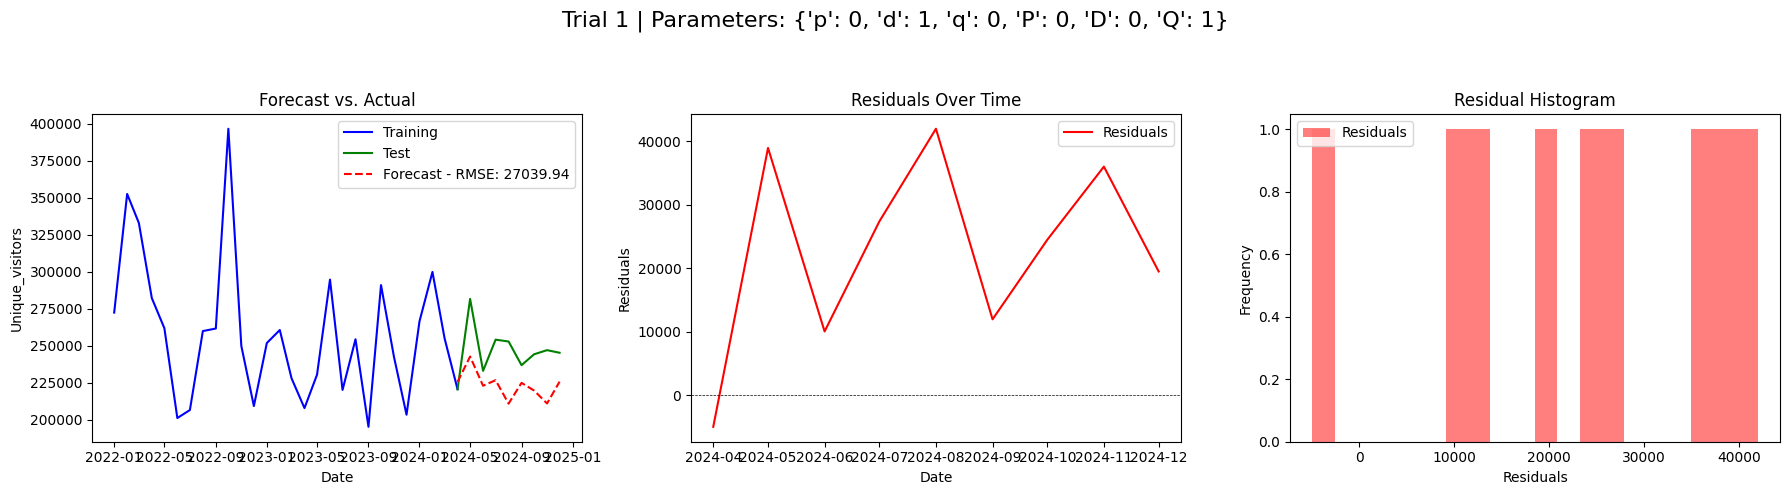


--- Trial 5 with Parameters: {'p': 1, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 0} ---
Metrics: MSE: 1044323939.00, MAE: 24487.09, RMSE: 32316.00, R2: -3.11
AIC: 400.27, BIC: 404.14


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


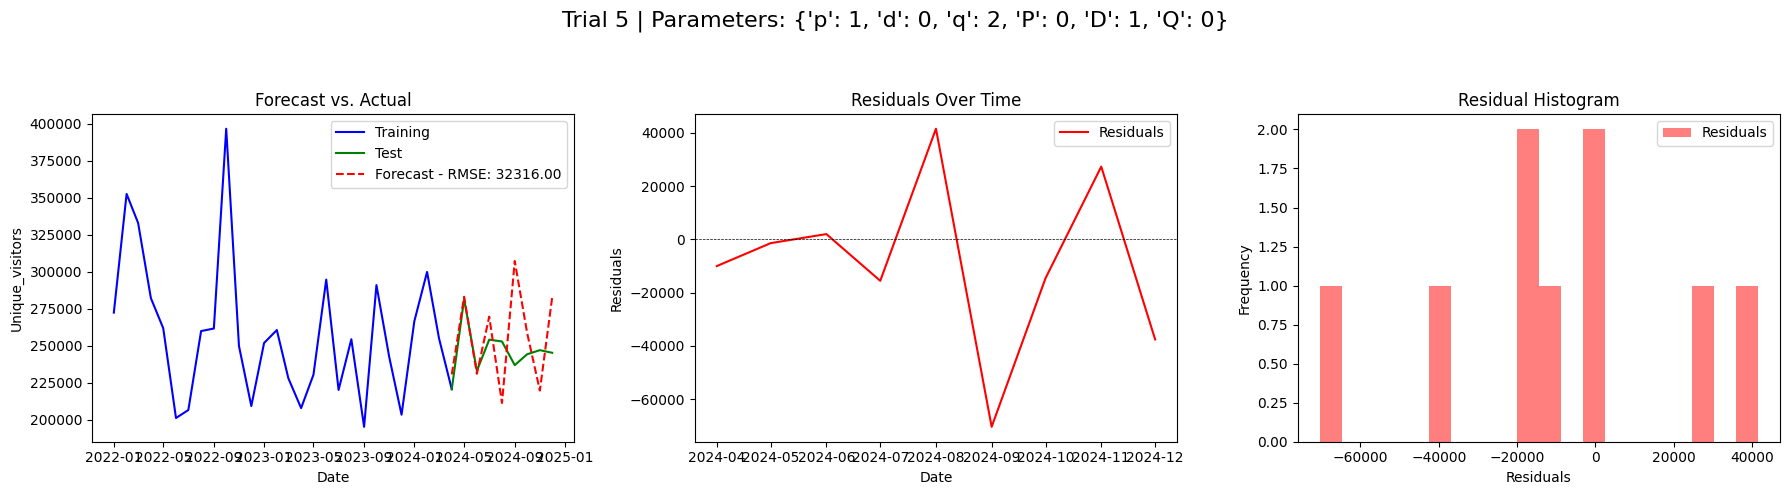


--- Trial 9 with Parameters: {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1} ---
Metrics: MSE: 660175884.00, MAE: 21905.89, RMSE: 25693.89, R2: -1.60
AIC: 675.57, BIC: 683.34


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

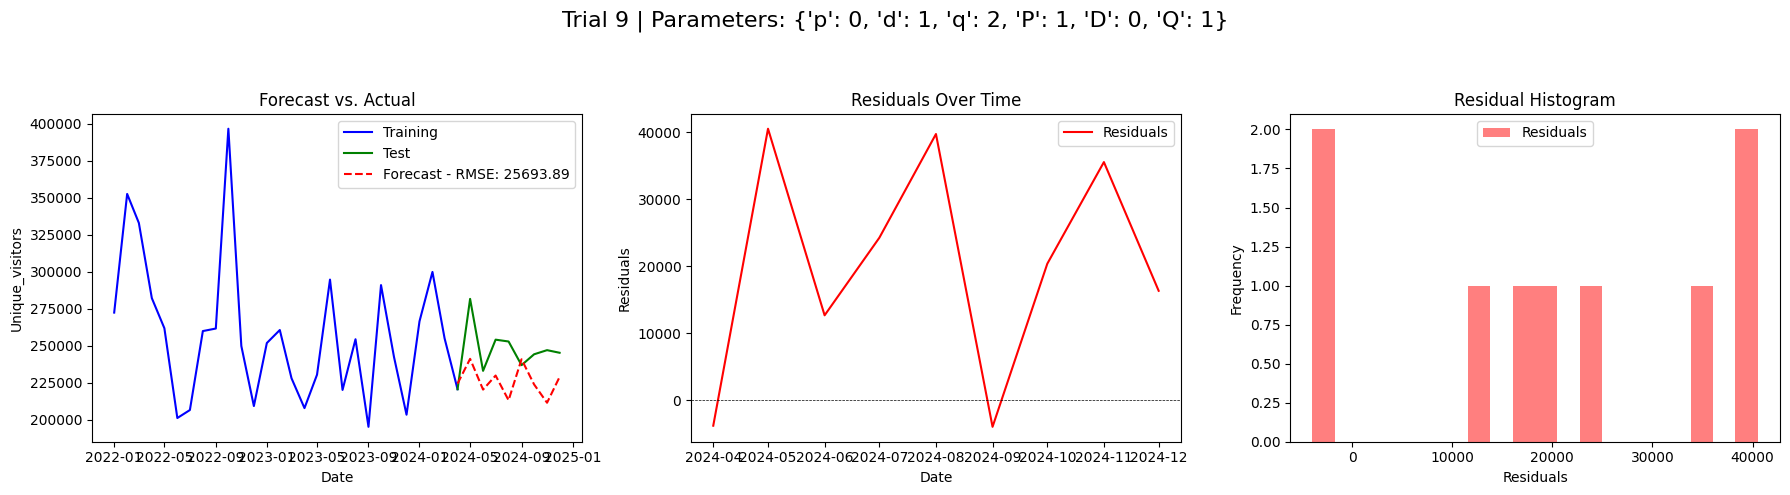


--- Trial 10 with Parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0} ---
Metrics: MSE: 327584265.25, MAE: 15737.99, RMSE: 18099.29, R2: -0.29
AIC: 686.66, BIC: 690.66


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


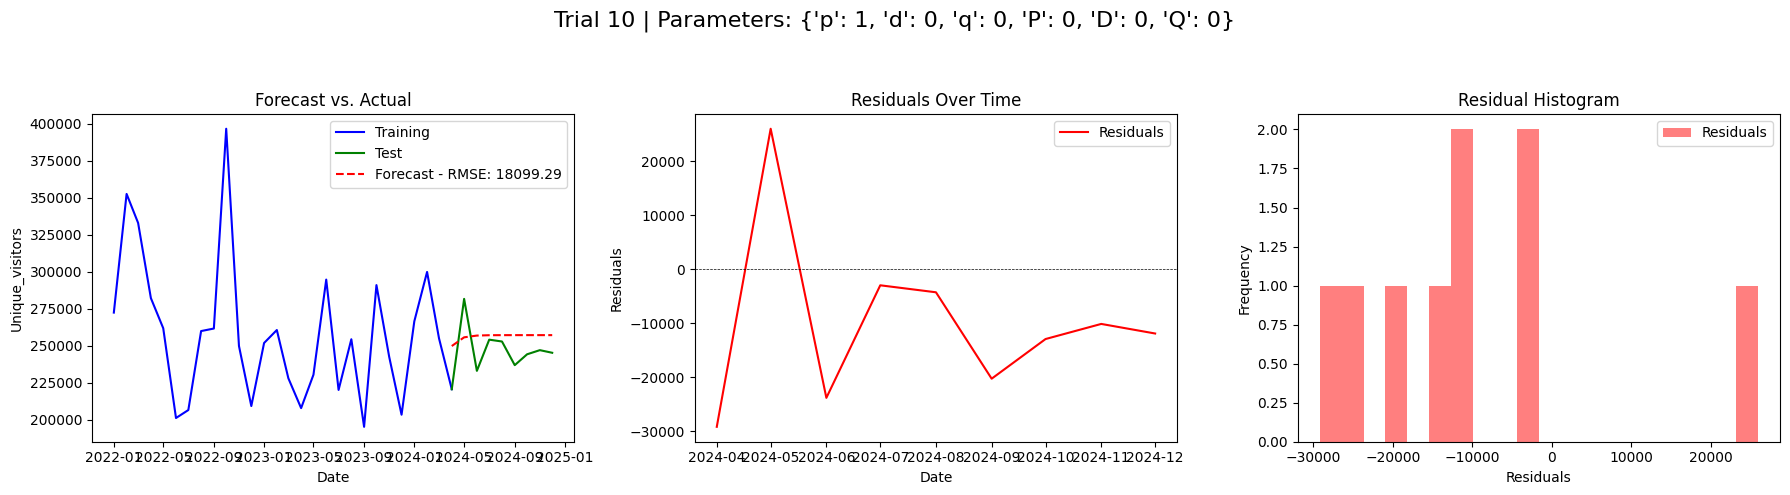


--- Trial 17 with Parameters: {'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 0} ---
Metrics: MSE: 1952624911.73, MAE: 34246.00, RMSE: 44188.52, R2: -6.69
AIC: 372.19, BIC: 375.02


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


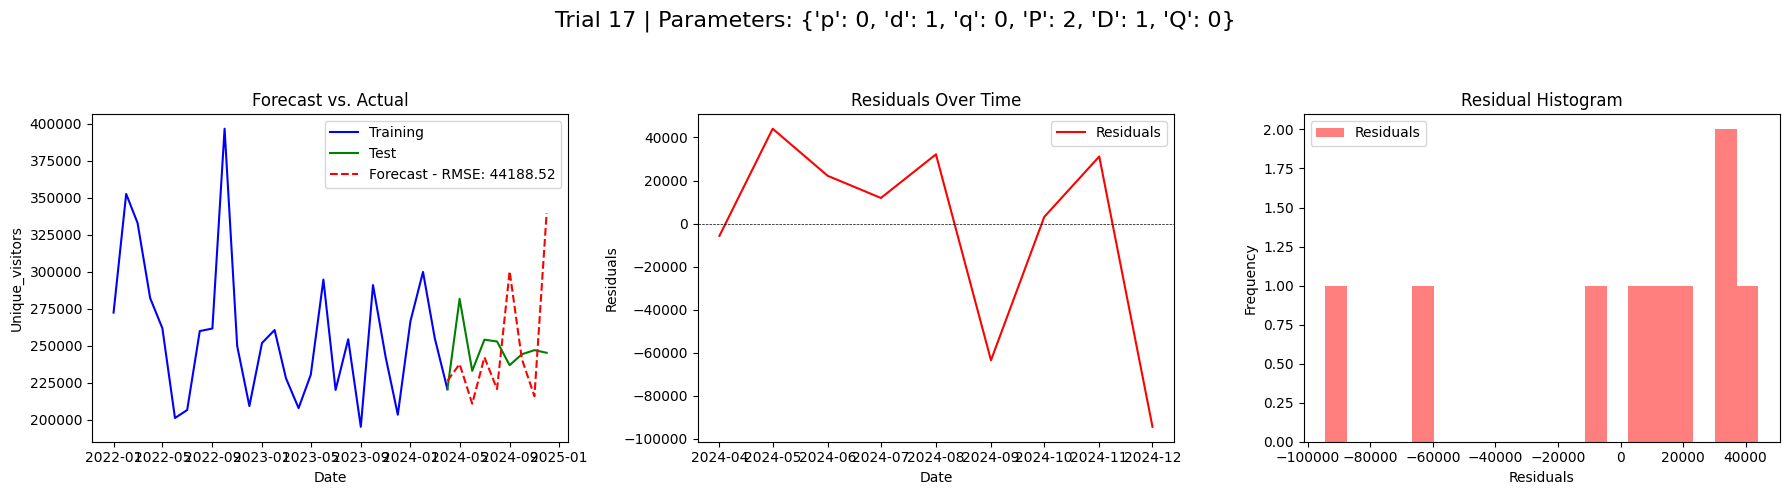


--- Trial 26 with Parameters: {'p': 1, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 0} ---
Metrics: MSE: 251904114.68, MAE: 10831.63, RMSE: 15871.49, R2: 0.01
AIC: 695.31, BIC: 704.64


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


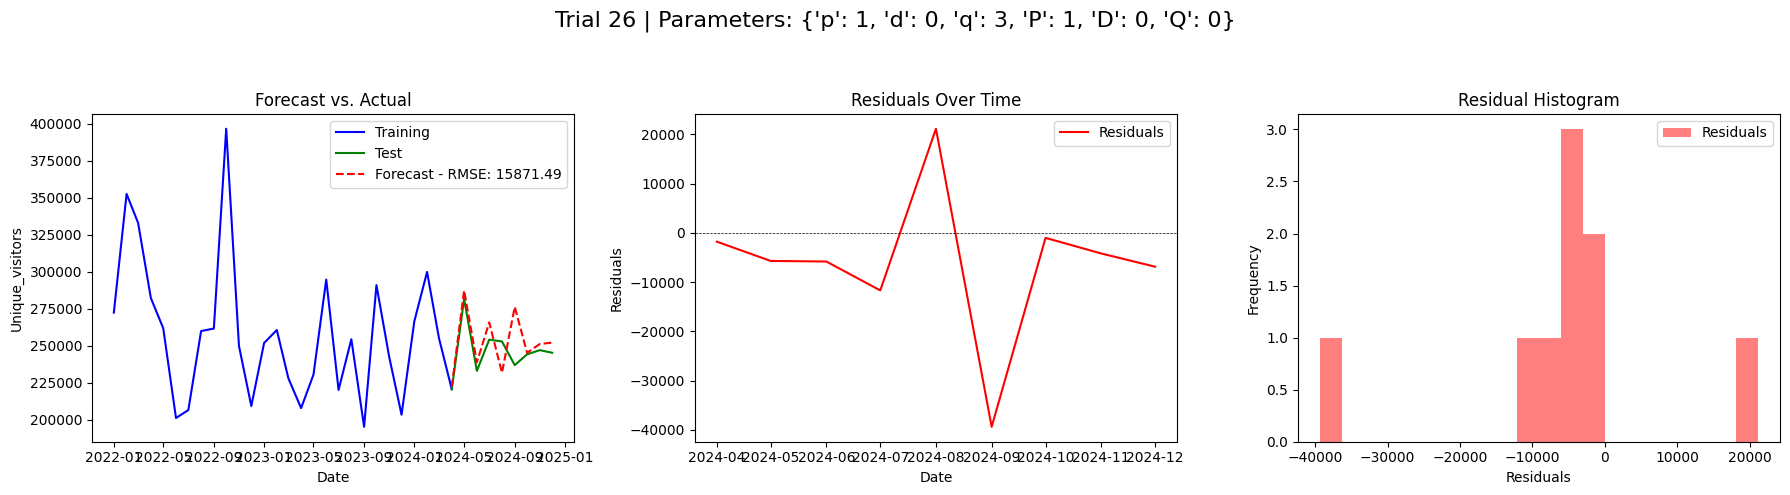


--- Trial 28 with Parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0} ---
Metrics: MSE: 327584265.25, MAE: 15737.99, RMSE: 18099.29, R2: -0.29
AIC: 686.66, BIC: 690.66


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


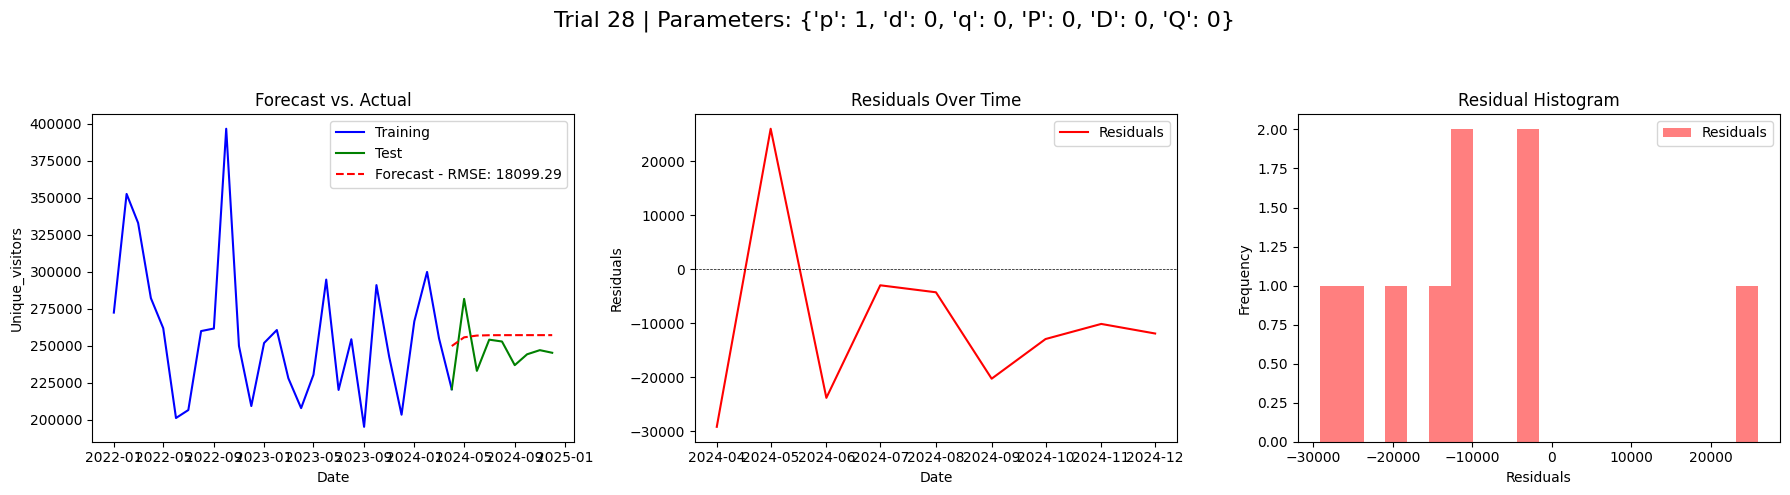


--- Trial 33 with Parameters: {'p': 0, 'd': 0, 'q': 3, 'P': 0, 'D': 0, 'Q': 0} ---
Metrics: MSE: 253479028.97, MAE: 12921.96, RMSE: 15921.02, R2: 0.00
AIC: 695.63, BIC: 702.29


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


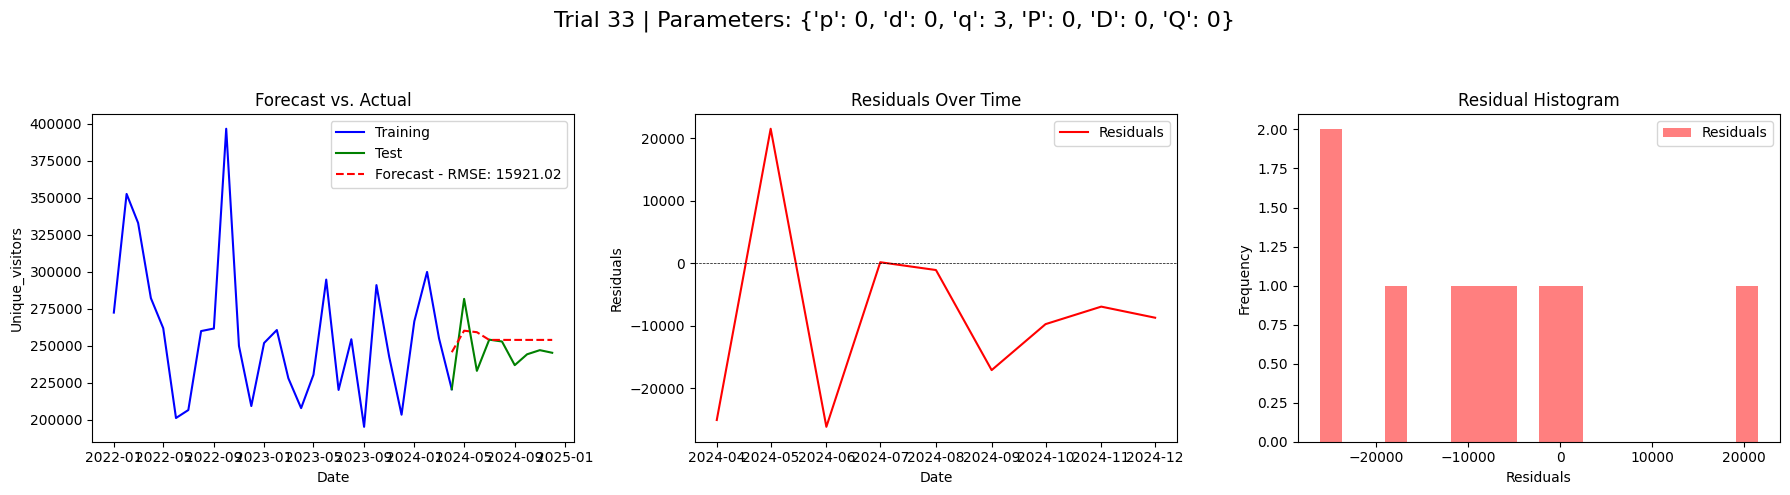


--- Trial 34 with Parameters: {'p': 2, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 2} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

Metrics: MSE: 915250109.62, MAE: 25092.46, RMSE: 30253.10, R2: -2.60
AIC: 681.66, BIC: 693.32


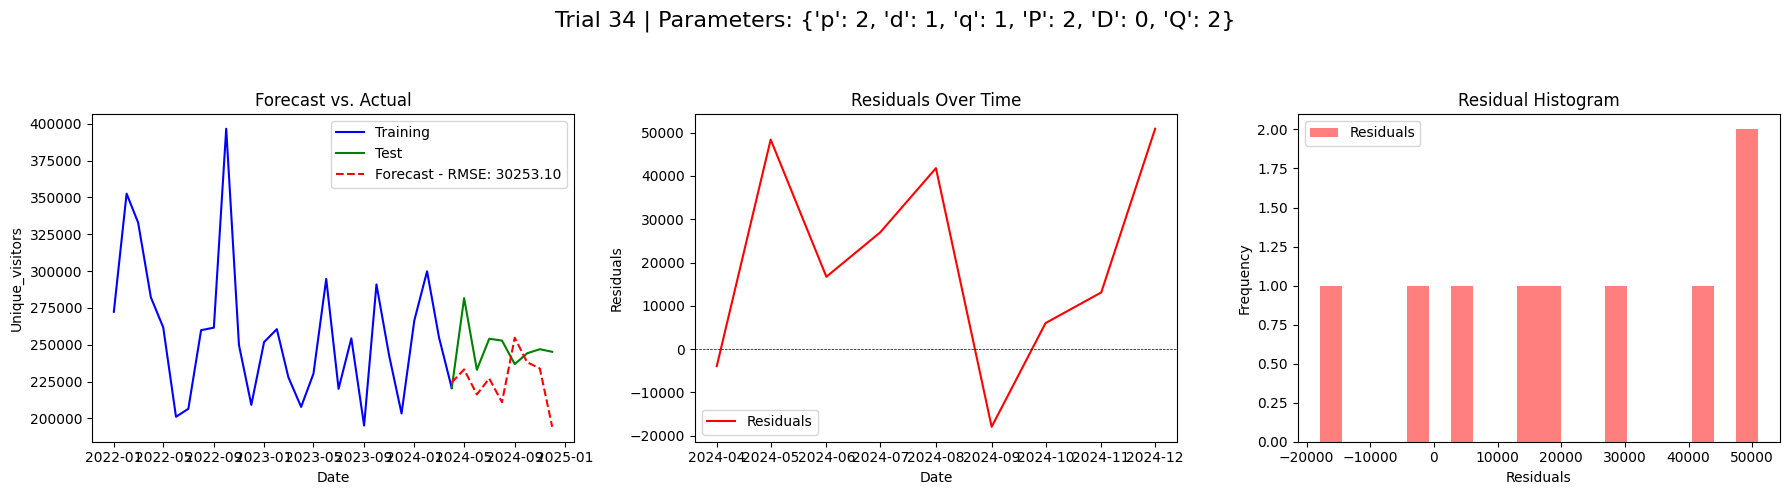


--- Trial 37 with Parameters: {'p': 2, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 2} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Metrics: MSE: 1152614102.39, MAE: 27574.37, RMSE: 33950.17, R2: -3.54
AIC: 393.82, BIC: 400.00


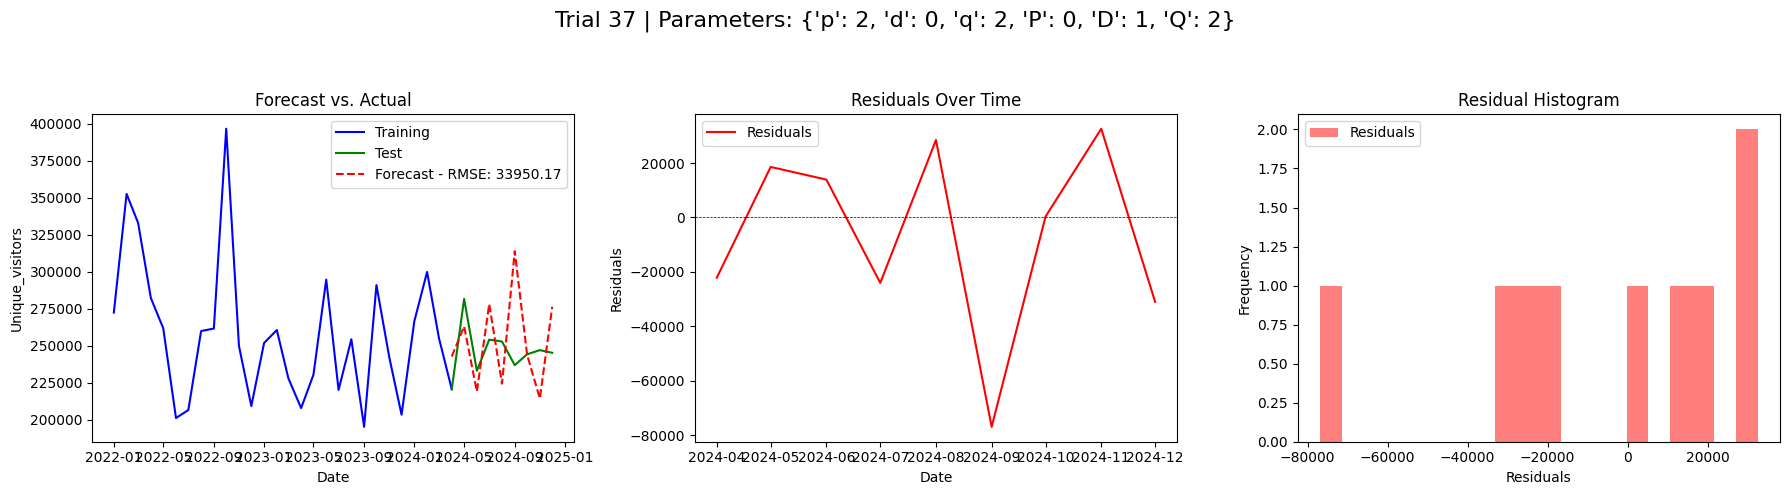


--- Trial 39 with Parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 1, 'D': 1, 'Q': 1} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few obser

Metrics: MSE: 1436545518.15, MAE: 31925.68, RMSE: 37901.79, R2: -4.66
AIC: 379.13, BIC: 386.08


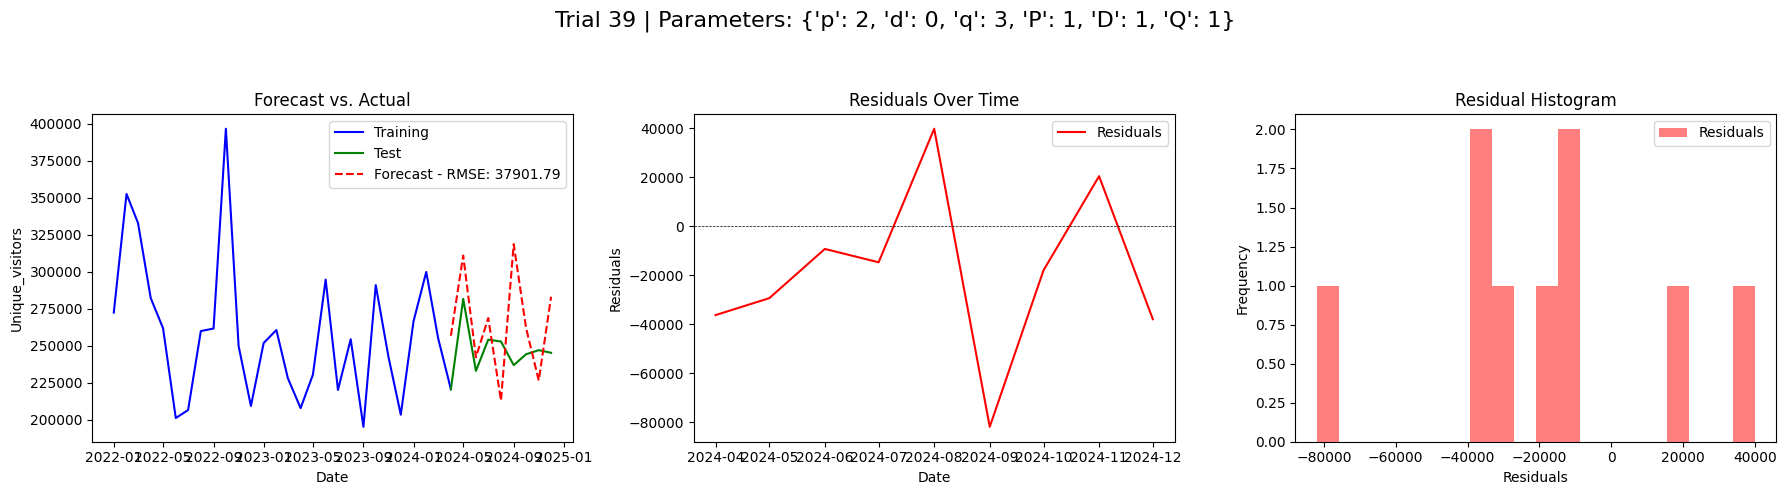


--- Trial 45 with Parameters: {'p': 2, 'd': 0, 'q': 1, 'P': 2, 'D': 0, 'Q': 0} ---


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Metrics: MSE: 271290321.44, MAE: 13707.88, RMSE: 16470.89, R2: -0.07
AIC: 693.38, BIC: 702.71


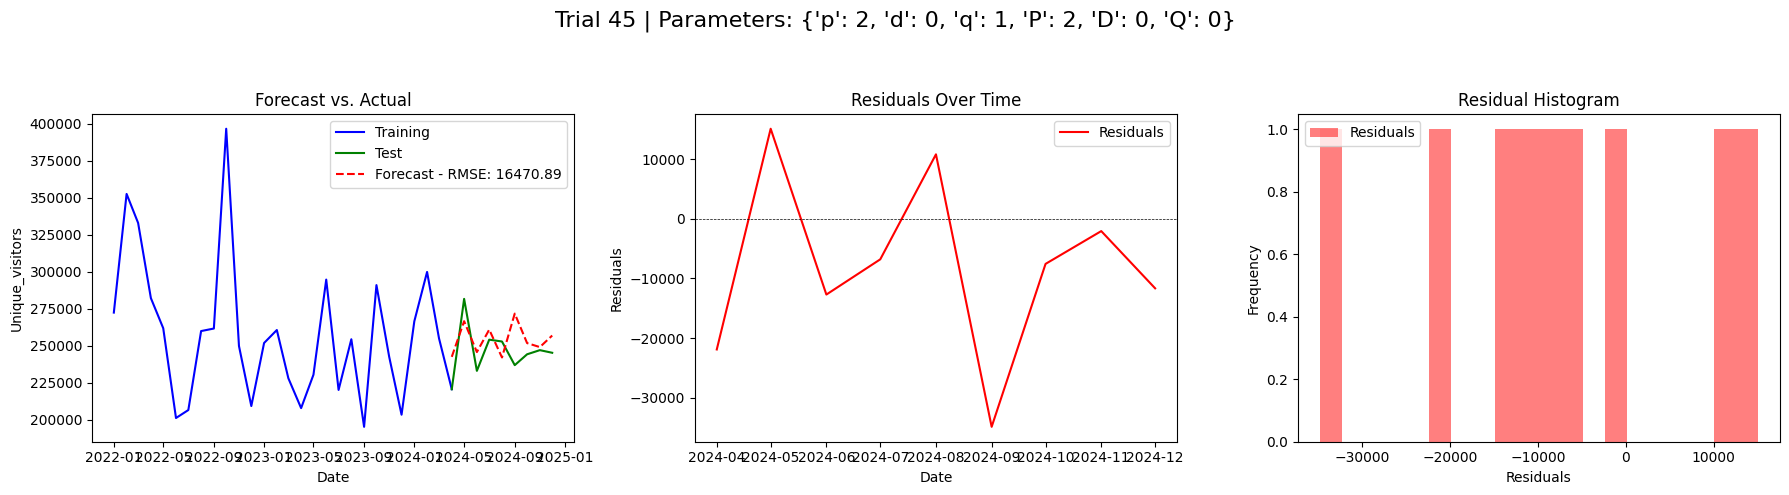


--- Trial 46 with Parameters: {'p': 0, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1} ---
Metrics: MSE: 1260588407.53, MAE: 25281.13, RMSE: 35504.77, R2: -3.96
AIC: 394.62, BIC: 398.48


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


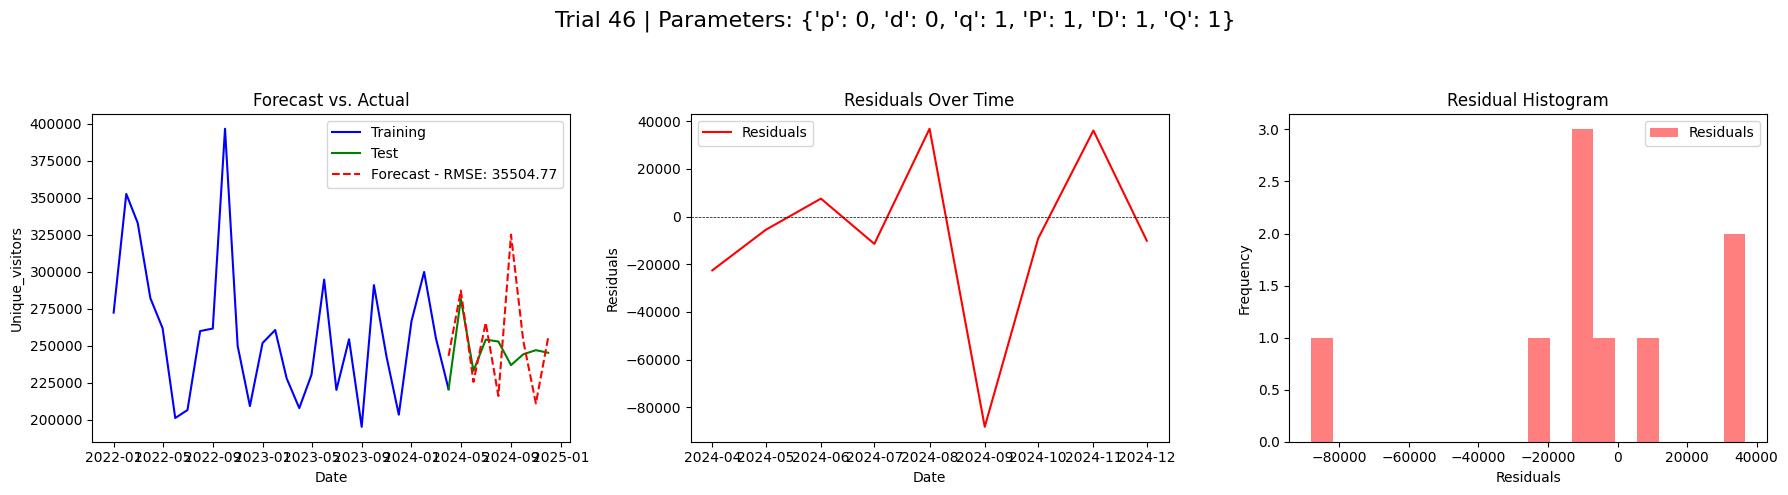

In [8]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from statsmodels.tsa.api import SARIMAX
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

# # ---------------------------
# # Pareto-Optimal Trials (provided parameters)
# # ---------------------------
# pareto_params = [
#     {'trial': 1, 'params': {'p': 0, 'd': 1, 'q': 0, 'P': 0, 'D': 0, 'Q': 1}},
#     {'trial': 5, 'params': {'p': 1, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 0}},
#     {'trial': 9, 'params': {'p': 0, 'd': 1, 'q': 2, 'P': 1, 'D': 0, 'Q': 1}},
#     {'trial': 10, 'params': {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0}},
#     {'trial': 17, 'params': {'p': 0, 'd': 1, 'q': 0, 'P': 2, 'D': 1, 'Q': 0}},
#     {'trial': 26, 'params': {'p': 1, 'd': 0, 'q': 3, 'P': 1, 'D': 0, 'Q': 0}},
#     {'trial': 28, 'params': {'p': 1, 'd': 0, 'q': 0, 'P': 0, 'D': 0, 'Q': 0}},
#     {'trial': 33, 'params': {'p': 0, 'd': 0, 'q': 3, 'P': 0, 'D': 0, 'Q': 0}},
#     {'trial': 34, 'params': {'p': 2, 'd': 1, 'q': 1, 'P': 2, 'D': 0, 'Q': 2}},
#     {'trial': 37, 'params': {'p': 2, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 2}},
#     {'trial': 39, 'params': {'p': 2, 'd': 0, 'q': 3, 'P': 1, 'D': 1, 'Q': 1}},
#     {'trial': 45, 'params': {'p': 2, 'd': 0, 'q': 1, 'P': 2, 'D': 0, 'Q': 0}},
#     {'trial': 46, 'params': {'p': 0, 'd': 0, 'q': 1, 'P': 1, 'D': 1, 'Q': 1}}
# ]

# # ---------------------------
# # Define a function to calculate metrics
# # ---------------------------
# def calculate_metrics(y_true, y_pred):
#     mse = mean_squared_error(y_true, y_pred)
#     mae = mean_absolute_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_true, y_pred)
#     return mse, mae, rmse, r2

# # ---------------------------
# # Loop over each Pareto-optimal parameter set and plot compact grid of graphs
# # ---------------------------
# for item in pareto_params:
#     trial_no = item['trial']
#     params = item['params']
#     print(f"\n--- Trial {trial_no} with Parameters: {params} ---")
    
#     # Define non-seasonal and seasonal orders
#     order = (params['p'], params['d'], params['q'])
#     seasonal_order = (params['P'], params['D'], params['Q'], 12)  # Seasonal period of 12
    
#     # Build and fit the SARIMAX model on training data
#     sarima_model = SARIMAX(train['Unique_visitors'],
#                            order=order,
#                            seasonal_order=seasonal_order,
#                            trend='c')
#     sarima_fit = sarima_model.fit(disp=False)
    
#     # Forecast using get_forecast for the test period length
#     forecast_obj = sarima_fit.get_forecast(steps=len(test))
#     sarima_predictions = forecast_obj.predicted_mean
#     sarima_predictions.index = test.index  # Align forecast index with test data
    
#     # Calculate performance metrics
#     mse, mae, rmse, r2 = calculate_metrics(test['Unique_visitors'], sarima_predictions)
#     print(f"Metrics: MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")
#     print(f"AIC: {sarima_fit.aic:.2f}, BIC: {sarima_fit.bic:.2f}")
    
#     # Calculate residuals
#     sarima_residuals = test['Unique_visitors'] - sarima_predictions
    
#     # Create a compact grid with 1 row and 3 columns
#     fig, axs = plt.subplots(1, 3, figsize=(18, 5))
#     fig.suptitle(f'Trial {trial_no} | Parameters: {params}', fontsize=16)
    
#     # Plot 1: Forecast vs. Actual Data
#     axs[0].plot(train.index, train['Unique_visitors'], label='Training', color='blue')
#     axs[0].plot(test.index, test['Unique_visitors'], label='Test', color='green')
#     axs[0].plot(test.index, sarima_predictions, label=f'Forecast - RMSE: {rmse:.2f}', linestyle='--', color='red')
#     axs[0].set_xlabel('Date')
#     axs[0].set_ylabel('Unique_visitors')
#     axs[0].set_title('Forecast vs. Actual')
#     axs[0].legend()
    
#     # Plot 2: Residuals Over Time
#     axs[1].plot(test.index, sarima_residuals, label='Residuals', color='red')
#     axs[1].axhline(y=0, color='black', linestyle='--', linewidth=0.5)
#     axs[1].set_xlabel('Date')
#     axs[1].set_ylabel('Residuals')
#     axs[1].set_title('Residuals Over Time')
#     axs[1].legend()
    
#     # Plot 3: Histogram of Residuals
#     axs[2].hist(sarima_residuals, bins=20, color='red', alpha=0.5, label='Residuals')
#     axs[2].set_xlabel('Residuals')
#     axs[2].set_ylabel('Frequency')
#     axs[2].set_title('Residual Histogram')
#     axs[2].legend()
    
#     plt.tight_layout(rect=[0, 0, 1, 0.92])
#     plt.show()

In [9]:
# import optuna
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_squared_error

# # Define your multi-objective objective function.
# # This function returns four values: RMSE, MAPE, AIC, and BIC.
# def objective(trial):
#     # Define the search space for SARIMA parameters
#     p = trial.suggest_int('p', 0, 3)
#     d = trial.suggest_int('d', 0, 1)
#     q = trial.suggest_int('q', 0, 3)
#     P = trial.suggest_int('P', 0, 2)
#     D = trial.suggest_int('D', 0, 1)
#     Q = trial.suggest_int('Q', 0, 2)
#     m = 12  # Seasonal period

#     try:
#         # Fit the SARIMAX model on the training data.
#         model = SARIMAX(train['Unique_visitors'],
#                         order=(p, d, q),
#                         seasonal_order=(P, D, Q, m),
#                         trend='c')
#         model_fit = model.fit(disp=False)
        
#         # Forecast for the test period.
#         predictions = model_fit.predict(start=len(train),
#                                         end=len(train) + len(test) - 1,
#                                         typ='levels')
        
#         # Calculate RMSE.
#         rmse = np.sqrt(mean_squared_error(test['Unique_visitors'], predictions))
        
#         # Calculate MAPE.
#         mape = np.mean(np.abs((test['Unique_visitors'] - predictions) / test['Unique_visitors'])) * 100
        
#         # Get AIC and BIC from the fitted model.
#         aic = model_fit.aic
#         bic = model_fit.bic
        
#     except Exception as e:
#         # Return high penalty values if the model fails.
#         return float('inf'), float('inf'), float('inf'), float('inf')
    
#     return rmse, mape, aic, bic

# # Create a multi-objective study (minimizing RMSE, MAPE, AIC, and BIC).
# study = optuna.create_study(directions=["minimize", "minimize", "minimize", "minimize"])

# # Run the optimization (adjust the number of trials as needed).
# study.optimize(objective, n_trials=50)

# # Extract and print only the Pareto-optimal (best) trials.
# print("Pareto-optimal trials (best trade-offs among RMSE, MAPE, AIC, and BIC):")
# for trial in study.best_trials:
#     print("Trial number:", trial.number)
#     print("Objectives (RMSE, MAPE, AIC, BIC):", trial.values)
#     print("Parameters:", trial.params)
#     print("-" * 40)

[I 2025-04-10 16:19:58,447] A new study created in memory with name: no-name-23bc7d40-c26a-4518-8615-a7a16e0df925


/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warn

Pareto-optimal trials (best trade-offs among RMSE, MAPE, AIC, and BIC):
Trial number: 3
Objectives (RMSE, MAPE, AIC, BIC): [61912.985309661286, 19.40936628842844, 375.84948063040747, 377.9736312337141]
Parameters: {'p': 0, 'd': 1, 'q': 1, 'P': 0, 'D': 1, 'Q': 0}
----------------------------------------
Trial number: 8
Objectives (RMSE, MAPE, AIC, BIC): [50354.27682708871, 10.555503981222868, 378.1021927632632, 383.0585441709787]
Parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 2, 'D': 1, 'Q': 1}
----------------------------------------
Trial number: 10
Objectives (RMSE, MAPE, AIC, BIC): [49231.0262025485, 18.968571037979242, 375.06657958620923, 380.7309811950269]
Parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 0, 'D': 1, 'Q': 2}
----------------------------------------
Trial number: 11
Objectives (RMSE, MAPE, AIC, BIC): [38424.06905612875, 13.239979859505535, 381.0839267090712, 388.809813931469]
Parameters: {'p': 2, 'd': 0, 'q': 3, 'P': 1, 'D': 1, 'Q': 2}
----------------------------------------
Tr

# MODELANDO

/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Métricas del Modelo SARIMA (1,0,2)(1,0,0,12): (229569764.30523396, 13329.195228751358, 15151.559797764517, 0.09618910535801883)


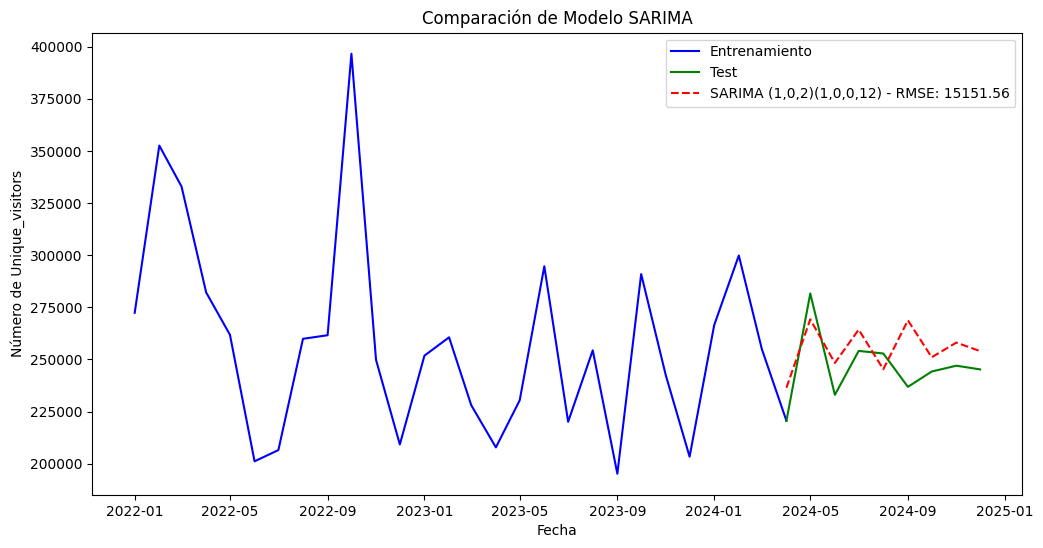

SARIMA - AIC: 690.9210018484715 BIC: 698.9142289095228

Coeficientes SARIMA (1,0,2)(1,0,0,12):
                                      SARIMAX Results                                      
Dep. Variable:                     Unique_visitors   No. Observations:                   28
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 12)   Log Likelihood                -339.461
Date:                             Thu, 10 Apr 2025   AIC                            690.921
Time:                                     16:20:08   BIC                            698.914
Sample:                                 01-01-2022   HQIC                           693.365
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  

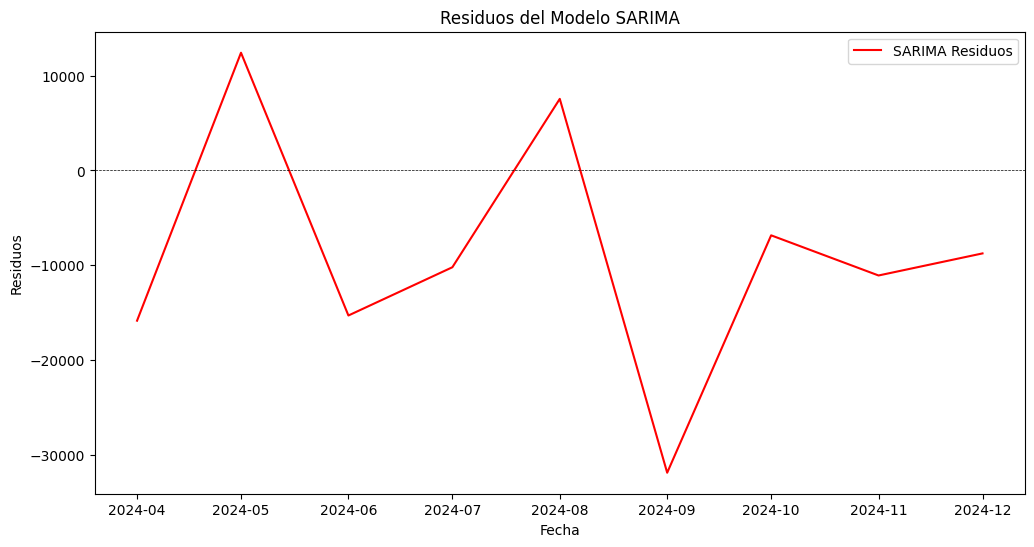

                Fecha  SARIMA Residuos
2024-04-01 2024-04-01    -15858.562342
2024-05-01 2024-05-01     12423.605260
2024-06-01 2024-06-01    -15310.681153
2024-07-01 2024-07-01    -10217.990249
2024-08-01 2024-08-01      7554.131123
2024-09-01 2024-09-01    -31904.138147
2024-10-01 2024-10-01     -6849.418115
2024-11-01 2024-11-01    -11086.895910
2024-12-01 2024-12-01     -8757.334761


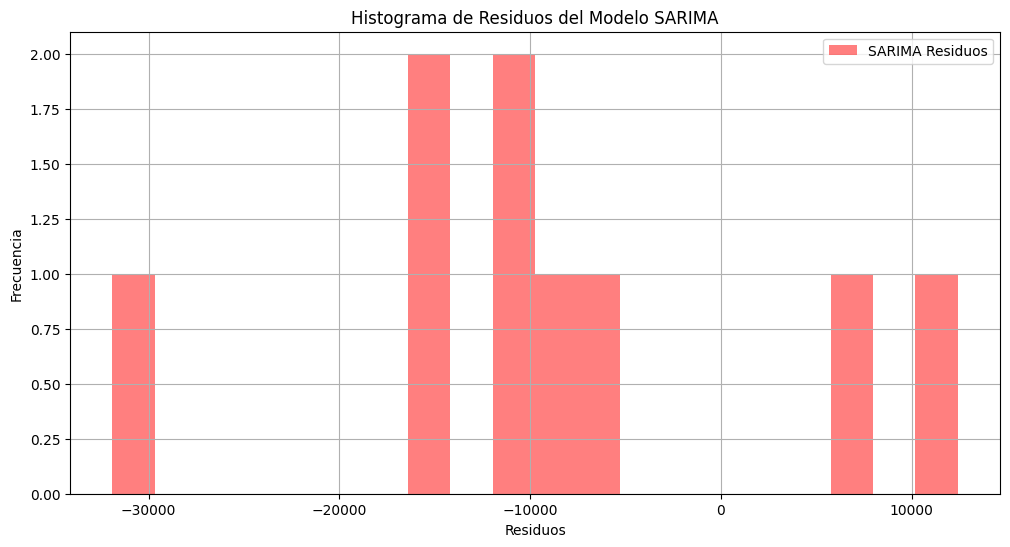

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

           

sarima_model = SARIMAX(train['Unique_visitors'],
                       order=(1, 0, 2),
                       seasonal_order=(1, 0, 0, 12),
                       trend='c')

sarima_fit = sarima_model.fit()
forecast_obj = sarima_fit.get_forecast(steps=len(test))
sarima_predictions = forecast_obj.predicted_mean

sarima_predictions.index = test.index

# --- Metric Calculation Function ---
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

sarima_metrics = calcular_metricas(test['Unique_visitors'], sarima_predictions)

# --- Printing Metrics ---
print("Métricas del Modelo SARIMA (1,0,2)(1,0,0,12):", sarima_metrics)

# --- Plotting the Forecast ---
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Unique_visitors'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Unique_visitors'], label='Test', color='green')
plt.plot(test.index, sarima_predictions,
         label=f'SARIMA (1,0,2)(1,0,0,12) - RMSE: {sarima_metrics[2]:.2f}',
         linestyle='--', color='red')
plt.xlabel('Fecha')
plt.ylabel('Número de Unique_visitors')
plt.title('Comparación de Modelo SARIMA')
plt.legend()
plt.show()

# --- Print AIC, BIC and Model Summary ---
print("SARIMA - AIC:", sarima_fit.aic, "BIC:", sarima_fit.bic)
print("\nCoeficientes SARIMA (1,0,2)(1,0,0,12):")
print(sarima_fit.summary())

# --- Residual Analysis ---
sarima_residuals = test['Unique_visitors'] - sarima_predictions

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(test.index, sarima_residuals, label='SARIMA Residuos', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del Modelo SARIMA')
plt.legend()
plt.show()

# Create a DataFrame for the residuals and print it
residuals_df = pd.DataFrame({
    'Fecha': test.index,
    'SARIMA Residuos': sarima_residuals
})
print(residuals_df)

# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(sarima_residuals, bins=20, color='red', alpha=0.5, label='SARIMA Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos del Modelo SARIMA')
plt.legend()
plt.grid(True)
plt.show()

/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frankllonch/anaconda3/envs/porro/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


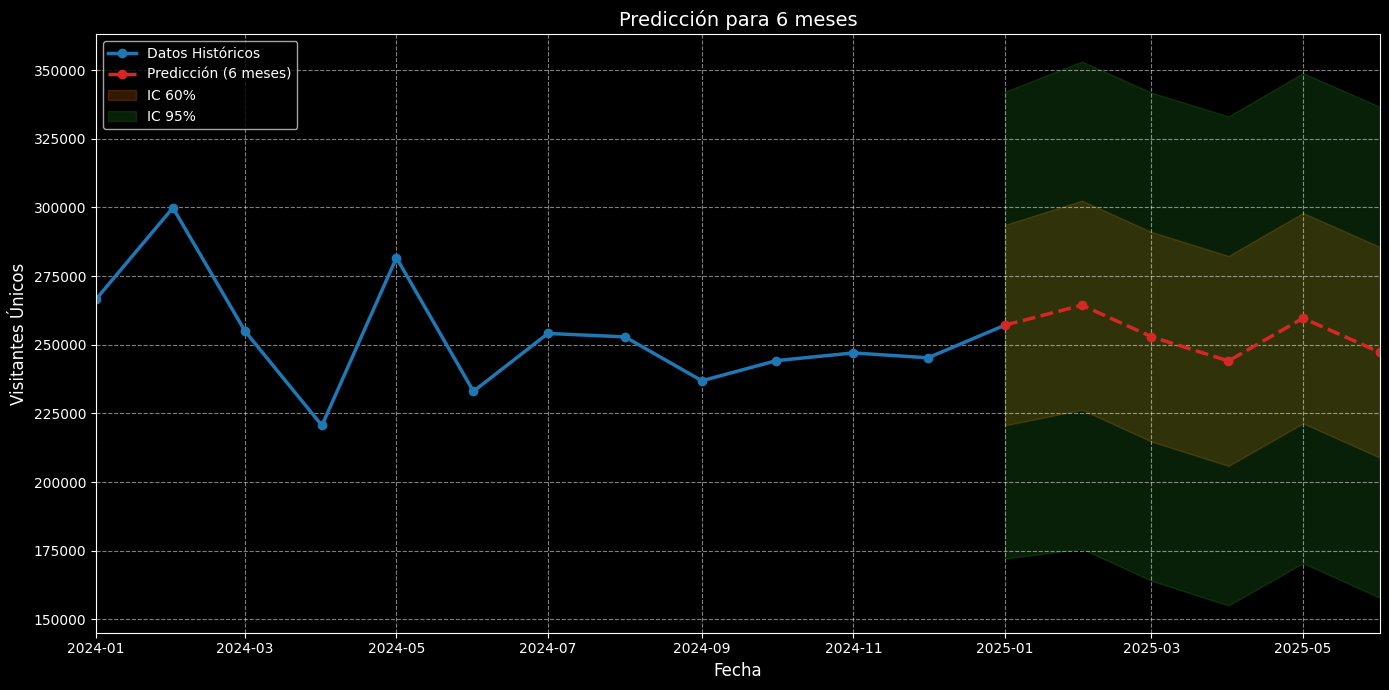


DETALLE DE PREDICCIONES:
     Fecha  Predicción  IC 75% Inferior  IC 75% Superior  IC 90% Inferior  IC 90% Superior
2025-01-01    257120.0         220618.0         293623.0         172114.0         342127.0
2025-02-01    264384.0         226287.0         302481.0         175664.0         353104.0
2025-03-01    252893.0         214725.0         291061.0         164007.0         341778.0
2025-04-01    244082.0         205843.0         282321.0         155031.0         333133.0
2025-05-01    259671.0         221361.0         297981.0         170454.0         348887.0
2025-06-01    247222.0         208841.0         285603.0         157840.0         336603.0


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SARIMAX
import numpy as np

# 1. Ajustar el modelo SARIMA
sarima_model = SARIMAX(df['Unique_visitors'], 
                      order=(1, 0, 2), 
                      seasonal_order=(1, 0, 0, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2. Configurar predicción de 6 meses
forecast_months = 6
last_date = df.index[-1]

# Generar fechas de predicción correctamente alineadas (primer día de cada mes)
prediction_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                                periods=forecast_months, 
                                freq='MS')

# Obtener predicción con intervalos
forecast = sarima_fit.get_forecast(steps=forecast_months)
predictions = pd.Series(forecast.predicted_mean.values, index=prediction_dates)
conf_75 = pd.DataFrame(forecast.conf_int(alpha=0.4).values, 
                      index=prediction_dates, 
                      columns=['lower', 'upper'])
conf_90 = pd.DataFrame(forecast.conf_int(alpha=0.05).values, 
                      index=prediction_dates, 
                      columns=['lower', 'upper'])

# 3. Preparar datos para gráfico (últimos 12 meses históricos)
show_last = 12
historical_data = df['Unique_visitors'].iloc[-show_last:]

# 4. Gráfico con conexión manual en azul
plt.figure(figsize=(14, 7))

# Datos históricos (azul)
plt.plot(historical_data.index, historical_data, 
         label='Datos Históricos', 
         color='#1f77b4', 
         linewidth=2.5,
         marker='o')

# Línea de conexión MANUAL (azul continuo)
plt.plot([historical_data.index[-1], prediction_dates[0]], 
         [historical_data.iloc[-1], predictions.iloc[0]], 
         color='#1f77b4', 
         linewidth=2.5)

# Predicciones (rojo)
plt.plot(predictions.index, predictions, 
         label=f'Predicción ({forecast_months} meses)',
         color='#d62728', 
         linestyle='--', 
         linewidth=2.5,
         marker='o')

# Intervalos de confianza
plt.fill_between(predictions.index, 
                 conf_75['lower'], 
                 conf_75['upper'], 
                 color='#ff7f0e', 
                 alpha=0.2, 
                 label='IC 60%')

plt.fill_between(predictions.index, 
                 conf_90['lower'], 
                 conf_90['upper'], 
                 color='#2ca02c', 
                 alpha=0.2, 
                 label='IC 95%')

# Personalización del gráfico
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Visitantes Únicos', fontsize=12)
plt.title(f'Predicción para {forecast_months} meses', fontsize=14)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Ajustar límites del eje x
plt.xlim(historical_data.index[0], predictions.index[-1])

plt.tight_layout()
plt.show()

# 5. Tabla de resultados
results_df = pd.DataFrame({
    'Fecha': predictions.index.strftime('%Y-%m-%d'),
    'Predicción': predictions.round(0),
    'IC 75% Inferior': conf_75['lower'].round(0),
    'IC 75% Superior': conf_75['upper'].round(0),
    'IC 90% Inferior': conf_90['lower'].round(0),
    'IC 90% Superior': conf_90['upper'].round(0)
})

print("\nDETALLE DE PREDICCIONES:")
print(results_df.to_string(index=False))